## 1.Environment Setup

In [1]:
# Import thư viện cần thiết
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

warnings.filterwarnings('ignore')

# Đặt seed để đảm bảo kết quả nhất quán giữa các lần chạy
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f"Seed: {SEED}")

Seed: 42


## 2.Data Processing

In [2]:
#!gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju

In [3]:
!gdown --fuzzy 'https://drive.google.com/file/d/1SOQO4eAKRcUmNP3sOwKkMWrFP7T7niGK/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1SOQO4eAKRcUmNP3sOwKkMWrFP7T7niGK
To: /kaggle/working/heart.csv
100%|██████████████████████████████████████| 38.1k/38.1k [00:00<00:00, 43.4MB/s]


In [4]:
data_1 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data', header=None, na_values='?')
data_2 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', header=None, na_values='?')
data_3 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data', header=None, na_values='?')
data_4 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data', header=None, na_values='?')
data_5 = pd.read_csv('/kaggle/working/heart.csv', na_values='?')
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']
data_1.columns = COLUMNS
data_2.columns = COLUMNS
data_3.columns = COLUMNS
data_4.columns = COLUMNS

data_1.dropna(how='all', inplace=True)
data_5

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


### Data Preprocessing

In [5]:
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler

In [6]:
# DATA_PATH = 'cleveland.csv'
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']

numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

K_features = 10

raw = pd.concat([data_1, data_2, data_3, data_4, data_5], ignore_index=True)
#raw.columns = COLUMNS

for c in ['age','trestbps','chol','thalach','oldpeak','ca','thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')


raw['target'] = (raw['target'] > 0).astype(int)
print("Shape:", raw.shape)
display(raw.head())
display(raw.isna().sum())

Shape: (1945, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28.0,1.0,2.0,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29.0,1.0,2.0,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29.0,1.0,2.0,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30.0,0.0,1.0,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31.0,0.0,2.0,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

In [7]:
# https://drive.google.com/drive/folders/1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7?usp=drive_link
# !gdown --folder 1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7

In [8]:
def read_csv(file_path):
    print(f"{file_path}")
    df = pd.read_csv(file_path)
    display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print("Shape df: ", df.shape)
    print("Shape X: ", X.shape)
    print("Shape y: ", y.shape)

    return X, y

In [9]:
TARGET = 'target'
raw_feature_cols = [c for c in raw.columns if c != TARGET]

X_all = raw[raw_feature_cols]
y_all = raw[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.4, stratify=y_all, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [10]:
cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])
num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_proc, numeric_cols),
    ('cat', cat_proc, categorical_cols),
])
raw_pipeline = Pipeline([
    ('preprocess', preprocess),
])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)

preprocessed_feature_names = []

for name, transformer, columns in preprocess.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        preprocessed_feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        preprocessed_feature_names.extend(columns)

# Build DataFrames with feature names
X_raw_train_df = pd.DataFrame(
    X_raw_train, columns=preprocessed_feature_names, index=X_train.index
)
X_raw_val_df = pd.DataFrame(
    X_raw_val, columns=preprocessed_feature_names, index=X_val.index
)
X_raw_test_df = pd.DataFrame(
    X_raw_test, columns=preprocessed_feature_names, index=X_test.index
)

# Save to CSV
out_dir = Path('splits')
out_dir.mkdir(parents=True, exist_ok=True)

pd.concat([X_raw_train_df, y_train.rename(TARGET)], axis=1).to_csv(
    out_dir / 'raw_train.csv', index=False
)
pd.concat([X_raw_val_df, y_val.rename(TARGET)], axis=1).to_csv(
    out_dir / 'raw_val.csv', index=False
)
pd.concat([X_raw_test_df, y_test.rename(TARGET)], axis=1).to_csv(
    out_dir / 'raw_test.csv', index=False
)

# Display DataFrame
display(X_raw_train_df)

,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
1645,0.682231,0.967803,0.406458,0.545631,1.441105,0.0,0.00,0.0,0.0,0.0,0.333333,0.50,0.428571
306,0.244056,-0.102591,0.383733,-0.049909,-0.340147,1.0,0.75,1.0,1.0,1.0,0.666667,0.25,0.857143
472,-1.180012,-0.102591,1.054101,0.744144,0.817666,1.0,0.75,0.0,0.0,0.0,0.333333,0.25,0.428571
655,0.244056,-0.905387,-2.524980,-2.432068,-1.765149,1.0,1.00,0.0,0.5,0.0,0.333333,0.00,0.428571
1353,-1.837275,-0.102591,0.315560,1.736711,2.242668,1.0,0.50,0.0,0.5,0.0,0.000000,0.00,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,1.449037,-0.637788,-2.524980,0.267712,0.461416,1.0,1.00,1.0,0.0,0.0,1.000000,0.00,0.428571
1218,-2.056362,-0.530749,-0.343445,1.220576,-0.874523,1.0,0.25,0.0,0.5,0.0,0.666667,0.00,0.285714
518,1.010863,-1.280025,0.531441,1.022063,0.728604,0.0,1.00,0.0,0.0,1.0,0.666667,0.50,0.428571
135,-0.084575,0.432606,1.110912,0.744144,-0.874523,1.0,0.50,0.0,0.0,0.0,0.666667,0.00,0.428571


In [11]:
# Combine feature engineering and preprocessing
dt_feature_selection_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline
dt_feature_selection_pipeline.fit(X_train, y_train)

# Extract feature importances
# Need to update feature names after preprocessing and feature engineering
processed_feature_names = []
# Get the feature names after preprocessing
preprocessor = dt_feature_selection_pipeline.named_steps['preprocess']
for name, transformer, columns in preprocessor.transformers_:
     if hasattr(transformer, 'get_feature_names_out'):
        processed_feature_names.extend(transformer.get_feature_names_out(columns))
     else:
        processed_feature_names.extend(columns)

feature_importance_series = pd.Series(
    dt_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=processed_feature_names
)

# Sort features by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances)

# Select top K features
selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

# Filter datasets by selected features
# Need to apply the first part of the pipeline (feature adding and preprocessing) to get the transformed dataframes
X_train_processed = Pipeline(dt_feature_selection_pipeline.steps[:-1]).transform(X_train)
X_val_processed = Pipeline(dt_feature_selection_pipeline.steps[:-1]).transform(X_val)
X_test_processed = Pipeline(dt_feature_selection_pipeline.steps[:-1]).transform(X_test)

# Convert to DataFrames with correct column names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_feature_names, index=X_train.index)
X_val_processed_df = pd.DataFrame(X_val_processed, columns=processed_feature_names, index=X_val.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=processed_feature_names, index=X_test.index)


X_dt_train = X_train_processed_df[selected_features]
X_dt_val = X_val_processed_df[selected_features]
X_dt_test = X_test_processed_df[selected_features]

display(X_dt_train.head())

# Save reduced datasets to CSV
pd.concat([X_dt_train, y_train.rename(TARGET)], axis=1).to_csv(
    out_dir / 'dt_train.csv', index=False
)
pd.concat([X_dt_val, y_val.rename(TARGET)], axis=1).to_csv(
    out_dir / 'dt_val.csv', index=False
)
pd.concat([X_dt_test, y_test.rename(TARGET)], axis=1).to_csv(
    out_dir / 'dt_test.csv', index=False
)

cp          0.220848
chol        0.131505
age         0.102201
oldpeak     0.095396
ca          0.088210
thalach     0.077990
thal        0.074968
trestbps    0.050477
sex         0.047746
exang       0.037765
restecg     0.030917
fbs         0.025151
slope       0.016827
dtype: float64

Top 10 selected features: ['cp', 'chol', 'age', 'oldpeak', 'ca', 'thalach', 'thal', 'trestbps', 'sex', 'exang']


,cp,chol,age,oldpeak,ca,thalach,thal,trestbps,sex,exang
1645,0.00,0.406458,0.682231,1.441105,0.50,0.545631,0.428571,0.967803,0.0,0.0
306,0.75,0.383733,0.244056,-0.340147,0.25,-0.049909,0.857143,-0.102591,1.0,1.0
472,0.75,1.054101,-1.180012,0.817666,0.25,0.744144,0.428571,-0.102591,1.0,0.0
655,1.00,-2.524980,0.244056,-1.765149,0.00,-2.432068,0.428571,-0.905387,1.0,0.0
1353,0.50,0.315560,-1.837275,2.242668,0.00,1.736711,0.285714,-0.102591,1.0,0.0


In [12]:
def add_new_features_func(df):
    df = df.copy()
    if {'chol', 'age'} <= set(df.columns):
        df['chol_per_age'] = df['chol'] / df['age']
    if {'trestbps', 'age'} <= set(df.columns):
        df['bps_per_age'] = df['trestbps'] / df['age']
    if {'thalach', 'age'} <= set(df.columns):
        df['hr_ratio'] = df['thalach'] / df['age']
    if 'age' in df.columns:
        df['age_bin'] = pd.cut(df['age'], bins=5, labels=False).astype('category')
    return df

# ---------------------------
# Transformer class wrapper
# ---------------------------

from sklearn.base import BaseEstimator, TransformerMixin
class AddNewFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.columns_ = X.columns
        self.new_features_ = []
        if {'chol', 'age'} <= set(X.columns):
            self.new_features_.append('chol_per_age')
        if {'trestbps', 'age'} <= set(X.columns):
            self.new_features_.append('bps_per_age')
        if {'thalach', 'age'} <= set(X.columns):
            self.new_features_.append('hr_ratio')
        if 'age' in X.columns:
            self.new_features_.append('age_bin')
        return self

    def transform(self, X):
        return add_new_features_func(X)

    def get_feature_names_out(self, input_features=None):
        return list(self.columns_) + self.new_features_

# ---------------------------
# Feature groups
# ---------------------------
gen_num = ['chol_per_age', 'bps_per_age', 'hr_ratio']
gen_cat = ['age_bin']

all_nums = [c for c in numeric_cols] + gen_num
all_cats = [c for c in categorical_cols] + gen_cat

# ---------------------------
# Preprocessing pipelines
# ---------------------------
num_proc = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])

cat_proc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ---------------------------
# Full pipeline with feature engineering + preprocessing
# ---------------------------
pre = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')

fe_pre = Pipeline([
    ('add', AddNewFeaturesTransformer()),
    ('pre', pre),
]).set_output(transform='pandas')

# ---------------------------
# Transform datasets
# ---------------------------
Xt_tr = fe_pre.fit_transform(X_train, y_train)
Xt_va = fe_pre.transform(X_val)
Xt_te = fe_pre.transform(X_test)

# ---------------------------
# Remove constant (non-varying) columns
# ---------------------------
nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]

Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te = Xt_te[nz_cols]

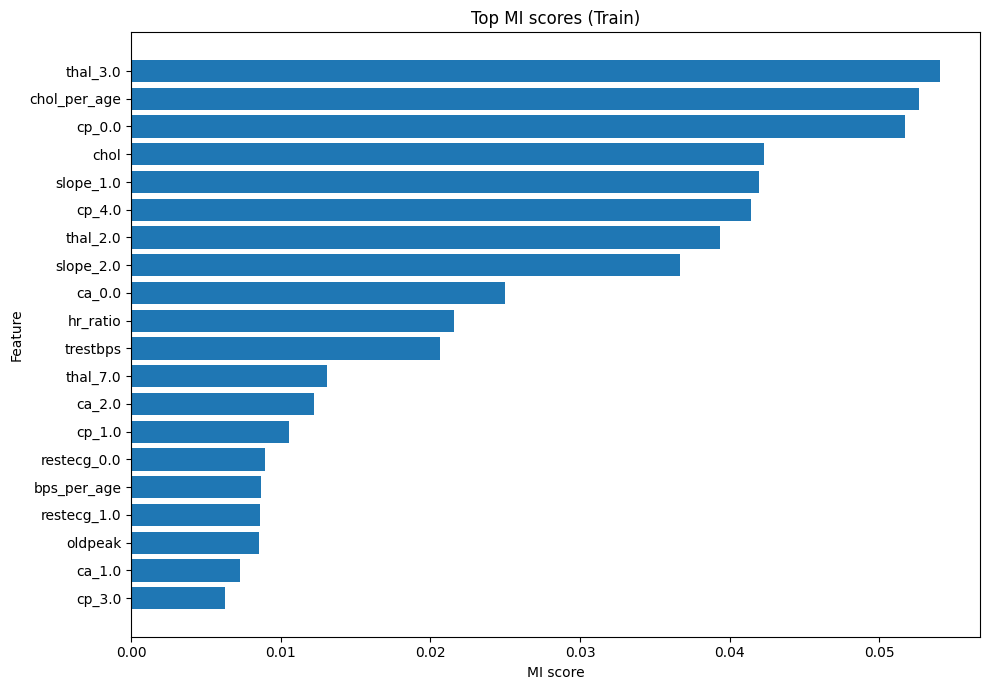

0         thal_3.0
1     chol_per_age
2           cp_0.0
3             chol
4        slope_1.0
5           cp_4.0
6         thal_2.0
7        slope_2.0
8           ca_0.0
9         hr_ratio
10        trestbps
11        thal_7.0
12          ca_2.0
Name: fe_topk_features, dtype: object

In [13]:
ohe = fe_pre.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(all_cats))

is_discrete = np.array([c in cat_names for c in Xt_tr.columns], dtype=bool)

mi = mutual_info_classif(
    Xt_tr.values, y_train.values,
    discrete_features=is_discrete,
    random_state=42
)

mi_series = pd.Series(mi, index=Xt_tr.columns).sort_values(ascending=False)

# Select top N features
N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]

# Plot MI scores
plt.figure(figsize=(10, max(6, 0.35 * N)))
plt.barh(topN.index, topN.values)
plt.title('Top MI scores (Train)')
plt.xlabel('MI score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('top_mi_scores.pdf', bbox_inches='tight')
plt.show()

# Select top K features based on raw columns (excluding target)
K = raw.columns.drop('target').shape[0]
topk_cols = list(mi_series.head(K).index)

# Create feature-engineered datasets
fe_tr = Xt_tr[topk_cols].assign(target=y_train.values)
fe_va = Xt_va[topk_cols].assign(target=y_val.values)
fe_te = Xt_te[topk_cols].assign(target=y_test.values)

# Save datasets
out = Path('splits')
out.mkdir(parents=True, exist_ok=True)

fe_tr.to_csv(out / 'fe_train.csv', index=False)
fe_va.to_csv(out / 'fe_val.csv', index=False)
fe_te.to_csv(out / 'fe_test.csv', index=False)

# Display top features
display(
    pd.Series(topk_cols, name='fe_topk_features').reset_index(drop=True)
)

In [14]:
dt_fe_feature_selection_pipeline = Pipeline([
    ('preprocess', fe_pre),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

# Fit pipeline
dt_fe_feature_selection_pipeline.fit(X_train, y_train)

# Extract feature names from preprocessing step
pipeline_feature_names = dt_fe_feature_selection_pipeline.named_steps['preprocess'].get_feature_names_out()

# Compute feature importances
feature_importance_series = pd.Series(
    dt_fe_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=pipeline_feature_names
)

# Sort by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances)

# Select top K features
selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

# Reduce datasets to selected features
X_fe_dt_train = Xt_tr[selected_features]
X_fe_dt_val = Xt_va[selected_features]
X_fe_dt_test = Xt_te[selected_features]

display(X_fe_dt_train.head())

# Save datasets with selected features
pd.concat([X_fe_dt_train, y_train.rename(TARGET)], axis=1).to_csv(
    out_dir / 'fe_dt_train.csv', index=False
)
pd.concat([X_fe_dt_val, y_val.rename(TARGET)], axis=1).to_csv(
    out_dir / 'fe_dt_val.csv', index=False
)
pd.concat([X_fe_dt_test, y_test.rename(TARGET)], axis=1).to_csv(
    out_dir / 'fe_dt_test.csv', index=False
)

chol_per_age    0.122672
cp_4.0          0.111779
thal_3.0        0.105296
oldpeak         0.080546
hr_ratio        0.071255
trestbps        0.060860
chol            0.057647
age             0.048524
thalach         0.047122
ca_0.0          0.046999
slope_2.0       0.043452
bps_per_age     0.042157
cp_0.0          0.024158
cp_1.0          0.021854
restecg_1.0     0.021525
sex_0.0         0.017249
age_bin_3.0     0.010525
fbs_1.0         0.009061
restecg_2.0     0.008422
thal_2.0        0.007922
thal_6.0        0.006266
restecg_0.0     0.005994
exang_1.0       0.005825
sex_1.0         0.005434
slope_1.0       0.004589
ca_1.0          0.004038
cp_3.0          0.003129
cp_2.0          0.003129
age_bin_2.0     0.002295
ca_2.0          0.000279
age_bin_1.0     0.000000
age_bin_0.0     0.000000
thal_7.0        0.000000
thal_1.0        0.000000
fbs_0.0         0.000000
slope_0.0       0.000000
thal_0.0        0.000000
ca_4.0          0.000000
ca_3.0          0.000000
exang_0.0       0.000000


Top 10 selected features: ['chol_per_age', 'cp_4.0', 'thal_3.0', 'oldpeak', 'hr_ratio', 'trestbps', 'chol', 'age', 'thalach', 'ca_0.0']


,chol_per_age,cp_4.0,thal_3.0,oldpeak,hr_ratio,trestbps,chol,age,thalach,ca_0.0
1645,0.027161,0.0,1.0,1.441105,-0.199137,0.967803,0.406458,0.682231,0.545631,0.0
306,0.176252,0.0,0.0,-0.340147,-0.293268,-0.102591,0.383733,0.244056,-0.049909,0.0
472,1.689062,0.0,1.0,0.817666,1.138971,-0.102591,1.054101,-1.180012,0.744144,0.0
655,-2.334758,1.0,1.0,-1.765149,-1.539113,-0.905387,-2.524980,0.244056,-2.432068,1.0
1353,1.376616,0.0,0.0,2.242668,2.635029,-0.102591,0.315560,-1.837275,1.736711,1.0


### Data Synthesis

In [15]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.3/193.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

In [16]:
from sdv.datasets.local import load_csvs
from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, CopulaGANSynthesizer
from sdv.utils import load_synthesizer

def synthetic_data(data, file_path, num_rows=100, save=True):
    """
    Generates synthetic data from a pandas DataFrame and saves it to a specified path.

    Args:
        data (pd.DataFrame): The original DataFrame.
        file_path (str): The path where the synthetic data will be saved.
        save (bool): Whether to save the synthetic data to a CSV file.
        num_rows (int): nuber of rows that you want to generate.
    Returns:
        tuple: A tuple containing the new DataFrame (original + synthetic) and the save file path.
    """
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    metadata = Metadata.detect_from_dataframe(data=data)
    synthesizer = CopulaGANSynthesizer(metadata)
    synthesizer.fit(data)
    synthetic_data = synthesizer.sample(num_rows=num_rows)
    new_data = pd.concat([data, synthetic_data], ignore_index=True)
    dir_name = os.path.dirname(file_path)
    new_file_name = f"{base_name}_synthetic.csv"
    new_file_path = os.path.join(dir_name, new_file_name)
    if save:
        new_data.to_csv(new_file_path, index=False)
        print(f"✅ Saved synthetic dataset to: {new_file_path}")
    return new_data, new_file_path

def synthetic(file_path, num_rows=100, save=True):
    data = pd.read_csv(file_path)
    return synthetic_data(data, file_path, num_rows=num_rows, save=save)

### 2.1 Original Dataset

In [17]:
X_train, y_train = read_csv('splits/raw_train.csv')
X_val, y_val = read_csv('splits/raw_val.csv')
X_test, y_test = read_csv('splits/raw_test.csv')

splits/raw_train.csv


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,0.682231,0.967803,0.406458,0.545631,1.441105,0.0,0.00,0.0,0.0,0.0,0.333333,0.50,0.428571,0
1,0.244056,-0.102591,0.383733,-0.049909,-0.340147,1.0,0.75,1.0,1.0,1.0,0.666667,0.25,0.857143,1
2,-1.180012,-0.102591,1.054101,0.744144,0.817666,1.0,0.75,0.0,0.0,0.0,0.333333,0.25,0.428571,0
3,0.244056,-0.905387,-2.524980,-2.432068,-1.765149,1.0,1.00,0.0,0.5,0.0,0.333333,0.00,0.428571,1
4,-1.837275,-0.102591,0.315560,1.736711,2.242668,1.0,0.50,0.0,0.5,0.0,0.000000,0.00,0.285714,1


target
1    621
0    546
Name: count, dtype: int64

Shape df:  (1167, 14)
Shape X:  (1167, 13)
Shape y:  (1167,)
splits/raw_val.csv


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.851381,-0.637788,0.304198,0.029496,-0.162022,1.0,0.00,0.0,0.0,0.0,0.666667,0.0,0.428571,0
1,1.558581,-0.637788,-0.127564,-1.121881,0.461416,0.0,0.50,0.0,0.0,0.0,0.333333,0.0,0.285714,1
2,-1.727731,-0.637788,0.099679,1.538197,2.509856,1.0,0.75,0.0,0.5,1.0,0.333333,0.0,0.428571,0
3,0.134513,-0.102591,0.065593,0.069199,-0.162022,1.0,0.75,0.0,0.5,0.0,0.666667,0.0,0.428571,1
4,0.572688,1.503000,0.576890,-0.724854,-0.874523,1.0,0.75,0.0,0.0,0.0,0.666667,0.0,0.285714,0


target
1    207
0    182
Name: count, dtype: int64

Shape df:  (389, 14)
Shape X:  (389, 13)
Shape y:  (389,)
splits/raw_test.csv


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,target
0,-0.960925,-1.065946,-0.707034,-0.208720,-0.874523,0.0,0.25,0.0,0.5,0.0,0.333333,0.00,0.285714,1
1,1.449037,-0.637788,0.076955,-0.566044,1.441105,1.0,0.00,0.0,0.0,1.0,0.333333,0.50,0.428571,0
2,0.463144,-0.102591,0.463268,-0.129314,0.906729,1.0,1.00,0.0,0.0,1.0,0.666667,0.00,0.428571,1
3,0.901319,-0.102591,0.463268,-1.836529,0.194228,0.0,0.50,0.0,0.5,0.0,0.333333,0.25,0.428571,0
4,-1.837275,-0.637788,0.429182,-0.526341,-0.874523,0.0,0.50,0.0,0.0,0.0,0.666667,0.00,0.428571,0


target
1    207
0    182
Name: count, dtype: int64

Shape df:  (389, 14)
Shape X:  (389, 13)
Shape y:  (389,)


### 2.2 FE Dataset

In [18]:
X_fe_train, y_fe_train = read_csv('splits/fe_train.csv')
X_fe_val, y_fe_val = read_csv('splits/fe_val.csv')
X_fe_test, y_fe_test = read_csv('splits/fe_test.csv')

splits/fe_train.csv


,thal_3.0,chol_per_age,cp_0.0,chol,slope_1.0,cp_4.0,thal_2.0,slope_2.0,ca_0.0,hr_ratio,trestbps,thal_7.0,ca_2.0,target
0,1.0,0.027161,1.0,0.406458,1.0,0.0,0.0,0.0,0.0,-0.199137,0.967803,0.0,1.0,0
1,0.0,0.176252,0.0,0.383733,0.0,0.0,0.0,1.0,0.0,-0.293268,-0.102591,0.0,0.0,1
2,1.0,1.689062,0.0,1.054101,1.0,0.0,0.0,0.0,0.0,1.138971,-0.102591,0.0,0.0,0
3,1.0,-2.334758,0.0,-2.524980,1.0,1.0,0.0,0.0,1.0,-1.539113,-0.905387,0.0,0.0,1
4,0.0,1.376616,0.0,0.315560,0.0,0.0,1.0,0.0,1.0,2.635029,-0.102591,0.0,0.0,1


target
1    621
0    546
Name: count, dtype: int64

Shape df:  (1167, 14)
Shape X:  (1167, 13)
Shape y:  (1167,)
splits/fe_val.csv


,thal_3.0,chol_per_age,cp_0.0,chol,slope_1.0,cp_4.0,thal_2.0,slope_2.0,ca_0.0,hr_ratio,trestbps,thal_7.0,ca_2.0,target
0,1.0,0.638537,1.0,0.304198,0.0,0.0,0.0,1.0,1.0,0.398266,-0.637788,0.0,0.0,0
1,0.0,-0.630364,0.0,-0.127564,1.0,0.0,1.0,0.0,1.0,-1.275287,-0.637788,0.0,0.0,1
2,1.0,1.004307,0.0,0.099679,1.0,0.0,0.0,0.0,1.0,2.327378,-0.637788,0.0,0.0,0
3,1.0,-0.057729,0.0,0.065593,0.0,0.0,0.0,1.0,1.0,-0.140998,-0.102591,0.0,0.0,1
4,0.0,0.206842,0.0,0.576890,0.0,0.0,1.0,1.0,1.0,-0.778232,1.503000,0.0,0.0,0


target
1    207
0    182
Name: count, dtype: int64

Shape df:  (389, 14)
Shape X:  (389, 13)
Shape y:  (389,)
splits/fe_test.csv


,thal_3.0,chol_per_age,cp_0.0,chol,slope_1.0,cp_4.0,thal_2.0,slope_2.0,ca_0.0,hr_ratio,trestbps,thal_7.0,ca_2.0,target
0,0.0,-0.381750,0.0,-0.707034,1.0,0.0,1.0,0.0,1.0,0.324117,-1.065946,0.0,0.0,1
1,1.0,-0.457356,1.0,0.076955,1.0,0.0,0.0,0.0,0.0,-1.002966,-0.637788,0.0,1.0,0
2,1.0,0.155958,0.0,0.463268,0.0,1.0,0.0,1.0,1.0,-0.435036,-0.102591,0.0,0.0,1
3,1.0,-0.004733,0.0,0.463268,1.0,0.0,0.0,0.0,0.0,-1.422566,-0.102591,0.0,0.0,0
4,1.0,1.525071,0.0,0.429182,0.0,0.0,0.0,1.0,1.0,0.843706,-0.637788,0.0,0.0,0


target
1    207
0    182
Name: count, dtype: int64

Shape df:  (389, 14)
Shape X:  (389, 13)
Shape y:  (389,)


### 2.3 Original + DT Dataset

In [19]:
X_dt_train, y_dt_train = read_csv('splits/dt_train.csv')
X_dt_val, y_dt_val = read_csv('splits/dt_val.csv')
X_dt_test, y_dt_test = read_csv('splits/dt_test.csv')

splits/dt_train.csv


,cp,chol,age,oldpeak,ca,thalach,thal,trestbps,sex,exang,target
0,0.00,0.406458,0.682231,1.441105,0.50,0.545631,0.428571,0.967803,0.0,0.0,0
1,0.75,0.383733,0.244056,-0.340147,0.25,-0.049909,0.857143,-0.102591,1.0,1.0,1
2,0.75,1.054101,-1.180012,0.817666,0.25,0.744144,0.428571,-0.102591,1.0,0.0,0
3,1.00,-2.524980,0.244056,-1.765149,0.00,-2.432068,0.428571,-0.905387,1.0,0.0,1
4,0.50,0.315560,-1.837275,2.242668,0.00,1.736711,0.285714,-0.102591,1.0,0.0,1


target
1    621
0    546
Name: count, dtype: int64

Shape df:  (1167, 11)
Shape X:  (1167, 10)
Shape y:  (1167,)
splits/dt_val.csv


,cp,chol,age,oldpeak,ca,thalach,thal,trestbps,sex,exang,target
0,0.00,0.304198,-0.851381,-0.162022,0.0,0.029496,0.428571,-0.637788,1.0,0.0,0
1,0.50,-0.127564,1.558581,0.461416,0.0,-1.121881,0.285714,-0.637788,0.0,0.0,1
2,0.75,0.099679,-1.727731,2.509856,0.0,1.538197,0.428571,-0.637788,1.0,1.0,0
3,0.75,0.065593,0.134513,-0.162022,0.0,0.069199,0.428571,-0.102591,1.0,0.0,1
4,0.75,0.576890,0.572688,-0.874523,0.0,-0.724854,0.285714,1.503000,1.0,0.0,0


target
1    207
0    182
Name: count, dtype: int64

Shape df:  (389, 11)
Shape X:  (389, 10)
Shape y:  (389,)
splits/dt_test.csv


,cp,chol,age,oldpeak,ca,thalach,thal,trestbps,sex,exang,target
0,0.25,-0.707034,-0.960925,-0.874523,0.00,-0.208720,0.285714,-1.065946,0.0,0.0,1
1,0.00,0.076955,1.449037,1.441105,0.50,-0.566044,0.428571,-0.637788,1.0,1.0,0
2,1.00,0.463268,0.463144,0.906729,0.00,-0.129314,0.428571,-0.102591,1.0,1.0,1
3,0.50,0.463268,0.901319,0.194228,0.25,-1.836529,0.428571,-0.102591,0.0,0.0,0
4,0.50,0.429182,-1.837275,-0.874523,0.00,-0.526341,0.428571,-0.637788,0.0,0.0,0


target
1    207
0    182
Name: count, dtype: int64

Shape df:  (389, 11)
Shape X:  (389, 10)
Shape y:  (389,)


### 2.4 FE + DT Dataset

In [20]:
X_fe_dt_train, y_fe_dt_train = read_csv('splits/fe_dt_train.csv')
X_fe_dt_val, y_fe_dt_val = read_csv('splits/fe_dt_val.csv')
X_fe_dt_test, y_fe_dt_test = read_csv('splits/fe_dt_test.csv')

splits/fe_dt_train.csv


,chol_per_age,cp_4.0,thal_3.0,oldpeak,hr_ratio,trestbps,chol,age,thalach,ca_0.0,target
0,0.027161,0.0,1.0,1.441105,-0.199137,0.967803,0.406458,0.682231,0.545631,0.0,0
1,0.176252,0.0,0.0,-0.340147,-0.293268,-0.102591,0.383733,0.244056,-0.049909,0.0,1
2,1.689062,0.0,1.0,0.817666,1.138971,-0.102591,1.054101,-1.180012,0.744144,0.0,0
3,-2.334758,1.0,1.0,-1.765149,-1.539113,-0.905387,-2.524980,0.244056,-2.432068,1.0,1
4,1.376616,0.0,0.0,2.242668,2.635029,-0.102591,0.315560,-1.837275,1.736711,1.0,1


target
1    621
0    546
Name: count, dtype: int64

Shape df:  (1167, 11)
Shape X:  (1167, 10)
Shape y:  (1167,)
splits/fe_dt_val.csv


,chol_per_age,cp_4.0,thal_3.0,oldpeak,hr_ratio,trestbps,chol,age,thalach,ca_0.0,target
0,0.638537,0.0,1.0,-0.162022,0.398266,-0.637788,0.304198,-0.851381,0.029496,1.0,0
1,-0.630364,0.0,0.0,0.461416,-1.275287,-0.637788,-0.127564,1.558581,-1.121881,1.0,1
2,1.004307,0.0,1.0,2.509856,2.327378,-0.637788,0.099679,-1.727731,1.538197,1.0,0
3,-0.057729,0.0,1.0,-0.162022,-0.140998,-0.102591,0.065593,0.134513,0.069199,1.0,1
4,0.206842,0.0,0.0,-0.874523,-0.778232,1.503000,0.576890,0.572688,-0.724854,1.0,0


target
1    207
0    182
Name: count, dtype: int64

Shape df:  (389, 11)
Shape X:  (389, 10)
Shape y:  (389,)
splits/fe_dt_test.csv


,chol_per_age,cp_4.0,thal_3.0,oldpeak,hr_ratio,trestbps,chol,age,thalach,ca_0.0,target
0,-0.381750,0.0,0.0,-0.874523,0.324117,-1.065946,-0.707034,-0.960925,-0.208720,1.0,1
1,-0.457356,0.0,1.0,1.441105,-1.002966,-0.637788,0.076955,1.449037,-0.566044,0.0,0
2,0.155958,1.0,1.0,0.906729,-0.435036,-0.102591,0.463268,0.463144,-0.129314,1.0,1
3,-0.004733,0.0,1.0,0.194228,-1.422566,-0.102591,0.463268,0.901319,-1.836529,0.0,0
4,1.525071,0.0,1.0,-0.874523,0.843706,-0.637788,0.429182,-1.837275,-0.526341,1.0,0


target
1    207
0    182
Name: count, dtype: int64

Shape df:  (389, 11)
Shape X:  (389, 10)
Shape y:  (389,)


## 3.Random Forest (RF)

In [21]:
def find_optimal_rf(
    X_train, y_train, n_estimators_range=range(50, 501, 10),
    cv_splits=5, max_depth=5, min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", bootstrap=True, class_weight=None
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    for n in n_estimators_range:
        rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            class_weight=class_weight,
            n_jobs=-1,
            random_state=SEED
        )
        cv_score = cross_val_score(
            rf, X_train, y_train,
            cv=cv, scoring='accuracy', n_jobs=-1
        )
        scores.append(cv_score.mean())

    # Lấy n_estimators tối ưu
    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f"n_estimators tối ưu (CV): {best_n}")

    # Vẽ biểu đồ chọn n_estimators theo CV
    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho Random Forest (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.savefig("rf.pdf", bbox_inches="tight")
    plt.show()

    # Train lại với toàn bộ X_train
    best_model = RandomForestClassifier(
        n_estimators=best_n, max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        n_jobs=-1, random_state=SEED
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)

def evaluate_val_rf(X_train, y_train, X_val, y_val,
                    n_estimators_range=range(50, 501, 10),
                    cv_splits=5, max_depth=5, max_features="sqrt",
                    min_samples_split=2, min_samples_leaf=1,
                    bootstrap=True, class_weight=None):
    print("Tìm n_estimators tối ưu cho Random Forest...")
    rf_model, best_n, cv_acc = find_optimal_rf(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight
    )

    # Dự đoán & báo cáo trên validation
    val_pred = rf_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"\nĐộ chính xác Random Forest trên tập validation: {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, val_pred))
    return rf_model, val_acc, {"n_estimators": best_n}

def evaluate_test_rf(rf_model, X_test, y_test):
    test_pred = rf_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"\nĐộ chính xác Random Forest trên tập test: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, test_pred))
    return test_acc

### 3.1 RF on Original Dataset

Tìm n_estimators tối ưu cho Random Forest...
n_estimators tối ưu (CV): 490


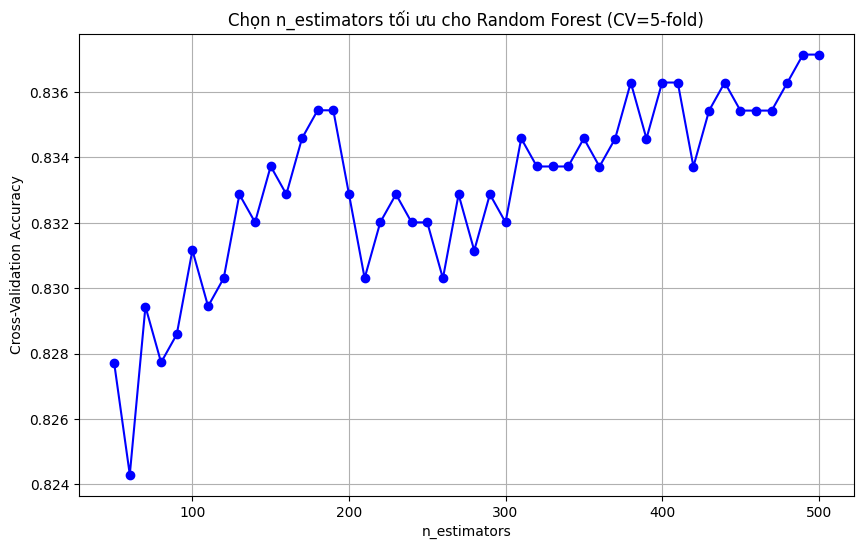


Độ chính xác Random Forest trên tập validation: 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       182
           1       0.88      0.85      0.86       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389


Độ chính xác Random Forest trên tập test: 0.8406
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       182
           1       0.84      0.87      0.85       207

    accuracy                           0.84       389
   macro avg       0.84      0.84      0.84       389
weighted avg       0.84      0.84      0.84       389



In [22]:
rf_model, val_acc, best_params = evaluate_val_rf(
    X_train, y_train, X_val, y_val)

test_acc = evaluate_test_rf(rf_model, X_test, y_test)

### 3.2 RF on Feature Engineering Dataset

Tìm n_estimators tối ưu cho Random Forest...
n_estimators tối ưu (CV): 50


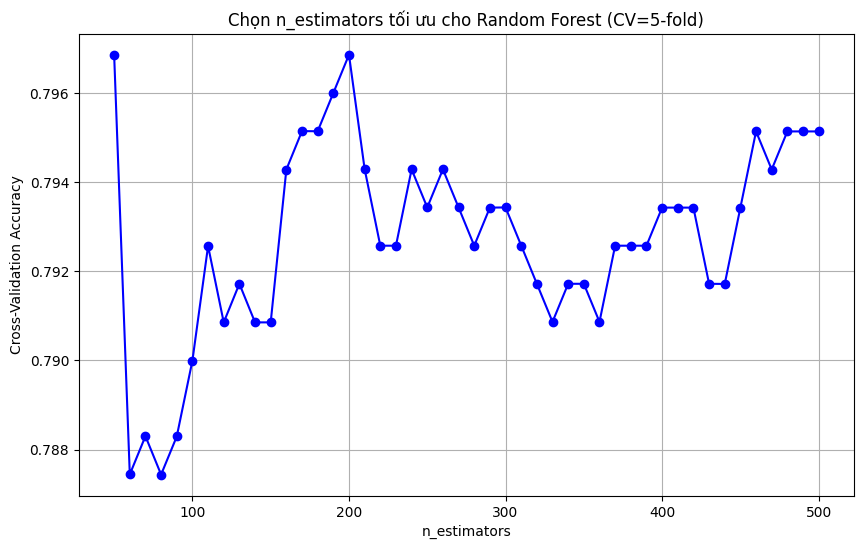


Độ chính xác Random Forest trên tập validation: 0.8432
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       182
           1       0.88      0.82      0.85       207

    accuracy                           0.84       389
   macro avg       0.84      0.85      0.84       389
weighted avg       0.85      0.84      0.84       389


Độ chính xác Random Forest trên tập test: 0.8175
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       182
           1       0.82      0.84      0.83       207

    accuracy                           0.82       389
   macro avg       0.82      0.82      0.82       389
weighted avg       0.82      0.82      0.82       389



In [23]:
rf_model, val_fe_acc, best_params = evaluate_val_rf(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val)

test_fe_acc = evaluate_test_rf(rf_model, X_fe_test, y_fe_test)

### 3.3 RF on Original DT Dataset

Tìm n_estimators tối ưu cho Random Forest...
n_estimators tối ưu (CV): 180


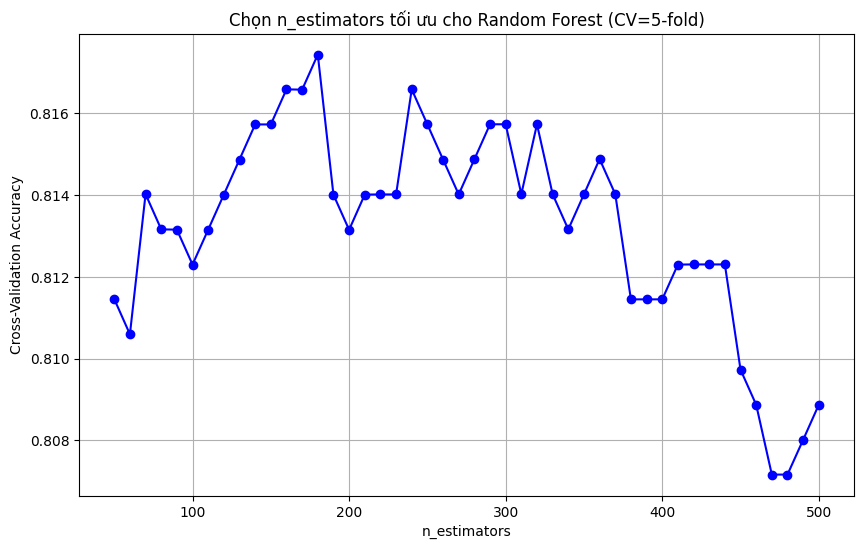


Độ chính xác Random Forest trên tập validation: 0.8535
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       182
           1       0.90      0.81      0.85       207

    accuracy                           0.85       389
   macro avg       0.86      0.86      0.85       389
weighted avg       0.86      0.85      0.85       389


Độ chính xác Random Forest trên tập test: 0.8252
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       182
           1       0.83      0.85      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.82      0.82       389
weighted avg       0.83      0.83      0.82       389



In [24]:
rf_model, val_dt_acc, best_params = evaluate_val_rf(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val)

test_dt_acc = evaluate_test_rf(rf_model, X_dt_test, y_dt_test)

### 3.4 RF on Feature Engineering DT Dataset

Tìm n_estimators tối ưu cho Random Forest...
n_estimators tối ưu (CV): 120


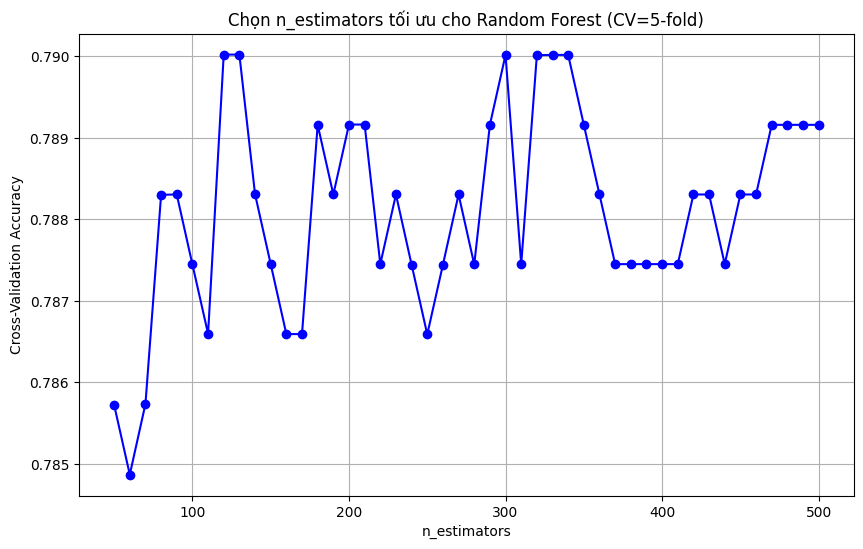


Độ chính xác Random Forest trên tập validation: 0.8329
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       182
           1       0.85      0.83      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389


Độ chính xác Random Forest trên tập test: 0.8123
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       182
           1       0.82      0.83      0.82       207

    accuracy                           0.81       389
   macro avg       0.81      0.81      0.81       389
weighted avg       0.81      0.81      0.81       389



In [25]:
rf_model, val_fe_dt_acc, best_params = evaluate_val_rf(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)

test_fe_dt_acc = evaluate_test_rf(rf_model, X_fe_dt_test, y_fe_dt_test)

### 3.5. RF (using RandomizedSearchCV) on Original Dataset

In [26]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score

def random_search(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 10),
    cv_splits=5, max_depth=range(1, 11, 1), min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", bootstrap=True, class_weight=None
):
    np.random.seed(SEED)
    random.seed(SEED)

    param_grid = {
        'n_estimators': list(n_estimators_range),
        'max_depth': list(max_depth)
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)

    random_search = HalvingRandomSearchCV(
        RandomForestClassifier(random_state=SEED,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap=bootstrap,
                               class_weight=class_weight,
                               max_features="sqrt",
                               n_jobs=-1),
        param_grid,
        n_candidates='exhaust',
        factor=20,
        random_state=SEED,
        cv=cv,
        verbose=10,
        n_jobs=-1,
    )
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    val_pred = best_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"\nĐộ chính xác Random Forest trên tập validation (RandomizedSearchCV): {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, val_pred))
    return best_model, val_acc, best_params

def grid_search(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 10),
    cv_splits=5, max_depth=range(1, 11, 1), min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", bootstrap=True, class_weight=None
):
    np.random.seed(SEED)
    random.seed(SEED)

    param_grid = {
        'n_estimators': list(n_estimators_range),
        'max_depth': list(max_depth)
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)

    grid_search = HalvingGridSearchCV(
        RandomForestClassifier(random_state=SEED,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               bootstrap=bootstrap,
                               class_weight=class_weight,
                               max_features="sqrt",
                               n_jobs=-1),
        param_grid,
        random_state=SEED,
        cv=cv,
        factor=20,
        verbose=10,
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    val_pred = best_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    print(f"\nĐộ chính xác Random Forest trên tập validation (GridSearchCV): {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, val_pred))
    return best_model, val_acc, best_params

In [27]:
rf_model, valgrid_acc, best_params = grid_search(
    X_train, y_train, X_val, y_val)

testgrid_acc = evaluate_test_rf(rf_model, X_test, y_test)

n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 1167
aggressive_elimination: False
factor: 20
----------
iter: 0
n_candidates: 460
n_resources: 20
Fitting 5 folds for each of 460 candidates, totalling 2300 fits
[CV 3/5; 1/460] START max_depth=1, n_estimators=50..............................
[CV 3/5; 1/460] END max_depth=1, n_estimators=50;, score=(train=0.938, test=0.333) total time=   0.2s
[CV 5/5; 1/460] START max_depth=1, n_estimators=50..............................
[CV 5/5; 1/460] END max_depth=1, n_estimators=50;, score=(train=0.750, test=1.000) total time=   0.2s
[CV 4/5; 2/460] START max_depth=1, n_estimators=60..............................
[CV 4/5; 2/460] END max_depth=1, n_estimators=60;, score=(train=0.875, test=1.000) total time=   0.2s
[CV 5/5; 2/460] START max_depth=1, n_estimators=60..............................
[CV 5/5; 2/460] END max_depth=1, n_estimators=60;, score=(train=0.750, test=1.000) total time=   0.2s
[CV 

In [28]:
rf_model, valrd_acc, best_params = random_search(
    X_train, y_train, X_val, y_val)

testrd_acc = evaluate_test_rf(rf_model, X_test, y_test)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 1167
aggressive_elimination: False
factor: 20
----------
iter: 0
n_candidates: 58
n_resources: 20
Fitting 5 folds for each of 58 candidates, totalling 290 fits

[CV 4/5; 457/460] START max_depth=10, n_estimators=470..........................
[CV 4/5; 457/460] END max_depth=10, n_estimators=470;, score=(train=1.000, test=1.000) total time=   1.4s
[CV 3/5; 458/460] START max_depth=10, n_estimators=480..........................
[CV 3/5; 458/460] END max_depth=10, n_estimators=480;, score=(train=1.000, test=0.333) total time=   1.4s
[CV 2/5; 459/460] START max_depth=10, n_estimators=490..........................
[CV 2/5; 459/460] END max_depth=10, n_estimators=490;, score=(train=1.000, test=0.250) total time=   1.4s
[CV 1/5; 460/460] START max_depth=10, n_estimators=500..........................
[CV 1/5; 460/460] END max_depth=10, n_estimators=500;, score=(train=1.000, test=0.750) total tim

### 3.6. RF (using RandomizedSearchCV & GridSearchCV) on FE dataset

In [29]:
rf_model, valgrid_fe_acc, best_params = grid_search(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val)

testgrid_fe_acc = evaluate_test_rf(rf_model, X_fe_test, y_fe_test)

n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 1167
aggressive_elimination: False
factor: 20
----------
iter: 0
n_candidates: 460
n_resources: 20
Fitting 5 folds for each of 460 candidates, totalling 2300 fits

[CV 3/5; 32/58] START max_depth=6, n_estimators=60..............................
[CV 3/5; 32/58] END max_depth=6, n_estimators=60;, score=(train=1.000, test=0.333) total time=   0.2s
[CV 3/5; 33/58] START max_depth=10, n_estimators=450............................
[CV 3/5; 33/58] END max_depth=10, n_estimators=450;, score=(train=1.000, test=0.333) total time=   1.3s
[CV 2/5; 34/58] START max_depth=7, n_estimators=230.............................
[CV 2/5; 34/58] END max_depth=7, n_estimators=230;, score=(train=1.000, test=0.250) total time=   0.7s
[CV 5/5; 34/58] START max_depth=7, n_estimators=230.............................
[CV 5/5; 34/58] END max_depth=7, n_estimators=230;, score=(train=1.000, test=1.000) total time=   0.7s

In [30]:
rf_model, valrd_fe_acc, best_params = random_search(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val)

testrd_fe_acc = evaluate_test_rf(rf_model, X_fe_test, y_fe_test)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 1167
aggressive_elimination: False
factor: 20
----------
iter: 0
n_candidates: 58
n_resources: 20
Fitting 5 folds for each of 58 candidates, totalling 290 fits

[CV 3/5; 448/460] END max_depth=10, n_estimators=380;, score=(train=1.000, test=0.333) total time=   1.2s
[CV 2/5; 449/460] START max_depth=10, n_estimators=390..........................
[CV 2/5; 449/460] END max_depth=10, n_estimators=390;, score=(train=1.000, test=0.250) total time=   1.2s
[CV 1/5; 450/460] START max_depth=10, n_estimators=400..........................
[CV 1/5; 450/460] END max_depth=10, n_estimators=400;, score=(train=1.000, test=0.500) total time=   1.2s
[CV 5/5; 450/460] START max_depth=10, n_estimators=400..........................
[CV 5/5; 450/460] END max_depth=10, n_estimators=400;, score=(train=1.000, test=1.000) total time=   1.2s
[CV 4/5; 451/460] START max_depth=10, n_estimators=410.................

### 3.7. RF (using RandomizedSearchCV & GridSearchCV) on Original DT dataset

In [31]:
rf_model, valgrid_dt_acc, best_params = grid_search(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val)

testgrid_dt_acc = evaluate_test_rf(rf_model, X_dt_test, y_dt_test)

n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 1167
aggressive_elimination: False
factor: 20
----------
iter: 0
n_candidates: 460
n_resources: 20
Fitting 5 folds for each of 460 candidates, totalling 2300 fits

[CV 5/5; 37/58] START max_depth=9, n_estimators=460.............................
[CV 5/5; 37/58] END max_depth=9, n_estimators=460;, score=(train=1.000, test=1.000) total time=   1.3s
[CV 1/5; 39/58] START max_depth=2, n_estimators=360.............................
[CV 1/5; 39/58] END max_depth=2, n_estimators=360;, score=(train=0.933, test=0.750) total time=   1.0s
[CV 5/5; 39/58] START max_depth=2, n_estimators=360.............................
[CV 5/5; 39/58] END max_depth=2, n_estimators=360;, score=(train=0.938, test=1.000) total time=   1.1s
[CV 4/5; 41/58] START max_depth=10, n_estimators=200............................
[CV 4/5; 41/58] END max_depth=10, n_estimators=200;, score=(train=1.000, test=1.000) total time=   0.6

In [32]:
rf_model, valrd_dt_acc, best_params = random_search(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val)

testrd_dt_acc = evaluate_test_rf(rf_model, X_dt_test, y_dt_test)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 1167
aggressive_elimination: False
factor: 20
----------
iter: 0
n_candidates: 58
n_resources: 20
Fitting 5 folds for each of 58 candidates, totalling 290 fits

[CV 1/5; 456/460] END max_depth=10, n_estimators=460;, score=(train=1.000, test=0.750) total time=   1.4s
[CV 5/5; 456/460] START max_depth=10, n_estimators=460..........................
[CV 5/5; 456/460] END max_depth=10, n_estimators=460;, score=(train=1.000, test=1.000) total time=   1.4s
[CV 4/5; 457/460] START max_depth=10, n_estimators=470..........................
[CV 4/5; 457/460] END max_depth=10, n_estimators=470;, score=(train=1.000, test=1.000) total time=   1.5s
[CV 3/5; 458/460] START max_depth=10, n_estimators=480..........................
[CV 3/5; 458/460] END max_depth=10, n_estimators=480;, score=(train=1.000, test=0.667) total time=   1.4s
[CV 2/5; 459/460] START max_depth=10, n_estimators=490.................

### 3.8. RF (using RandomizedSearchV & GridSearchCV) on FE DT dataset

In [33]:
rf_model, valgrid_fe_dt_acc, best_params = grid_search(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)

testgrid_fe_dt_acc = evaluate_test_rf(rf_model, X_fe_dt_test, y_fe_dt_test)

n_iterations: 2
n_required_iterations: 3
n_possible_iterations: 2
min_resources_: 20
max_resources_: 1167
aggressive_elimination: False
factor: 20
----------
iter: 0
n_candidates: 460
n_resources: 20
Fitting 5 folds for each of 460 candidates, totalling 2300 fits

[CV 5/5; 29/58] START max_depth=3, n_estimators=390.............................
[CV 5/5; 29/58] END max_depth=3, n_estimators=390;, score=(train=1.000, test=1.000) total time=   1.3s
[CV 2/5; 31/58] START max_depth=2, n_estimators=140.............................
[CV 2/5; 31/58] END max_depth=2, n_estimators=140;, score=(train=0.933, test=0.250) total time=   0.4s
[CV 1/5; 32/58] START max_depth=6, n_estimators=60..............................
[CV 1/5; 32/58] END max_depth=6, n_estimators=60;, score=(train=1.000, test=0.750) total time=   0.2s
[CV 4/5; 32/58] START max_depth=6, n_estimators=60..............................
[CV 4/5; 32/58] END max_depth=6, n_estimators=60;, score=(train=1.000, test=1.000) total time=   0.2s
[

In [34]:
rf_model, valrd_fe_dt_acc, best_params = random_search(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val)

testrd_fe_dt_acc = evaluate_test_rf(rf_model, X_fe_dt_test, y_fe_dt_test)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 1167
aggressive_elimination: False
factor: 20
----------
iter: 0
n_candidates: 58
n_resources: 20
Fitting 5 folds for each of 58 candidates, totalling 290 fits

[CV 3/5; 453/460] START max_depth=10, n_estimators=430..........................
[CV 3/5; 453/460] END max_depth=10, n_estimators=430;, score=(train=1.000, test=0.667) total time=   1.3s
[CV 2/5; 454/460] START max_depth=10, n_estimators=440..........................
[CV 2/5; 454/460] END max_depth=10, n_estimators=440;, score=(train=1.000, test=0.250) total time=   1.3s
[CV 1/5; 455/460] START max_depth=10, n_estimators=450..........................
[CV 1/5; 455/460] END max_depth=10, n_estimators=450;, score=(train=1.000, test=0.750) total time=   1.3s
[CV 5/5; 455/460] START max_depth=10, n_estimators=450..........................
[CV 5/5; 455/460] END max_depth=10, n_estimators=450;, score=(train=1.000, test=1.000) total tim

### Using Optuna for hyperparamater optimization

In [35]:
!pip install optuna

In [36]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state=SEED,
                                   n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the final model with the best hyperparameters
best_n_estimators = trial.params['n_estimators']
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators,
                                       random_state=SEED,
                                       n_jobs=-1,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       bootstrap=True,
                                       max_features="sqrt",
                                       max_depth=5)
best_rf_model.fit(X_train, y_train)

# Evaluate on the validation set
val_pred = best_rf_model.predict(X_val)
val_acc_optuna = accuracy_score(y_val, val_pred)
print(f"\nĐộ chính xác Random Forest trên tập validation (Optuna): {val_acc_optuna:.4f}")
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_rf(best_rf_model, X_test, y_test)

[I 2025-10-31 07:50:24,613] A new study created in memory with name: no-name-cfd2233e-e4ef-4640-b97b-0ce54b2ddf0b
[I 2025-10-31 07:50:27,568] Trial 0 finished with value: 0.8808847804555959 and parameters: {'n_estimators': 370}. Best is trial 0 with value: 0.8808847804555959.
[I 2025-10-31 07:50:28,694] Trial 1 finished with value: 0.8817321448222735 and parameters: {'n_estimators': 140}. Best is trial 1 with value: 0.8817321448222735.
[I 2025-10-31 07:50:31,764] Trial 2 finished with value: 0.8817358130662851 and parameters: {'n_estimators': 390}. Best is trial 2 with value: 0.8817358130662851.
[I 2025-10-31 07:50:32,424] Trial 3 finished with value: 0.8791607057701478 and parameters: {'n_estimators': 70}. Best is trial 2 with value: 0.8817358130662851.
[I 2025-10-31 07:50:35,499] Trial 4 finished with value: 0.8825941821649976 and parameters: {'n_estimators': 400}. Best is trial 4 with value: 0.8825941821649976.
[I 2025-10-31 07:50:38,781] Trial 5 finished with value: 0.8843109203624

Best trial:
  Value: 0.8860203220718242
  Params: 
    n_estimators: 450

Độ chính xác Random Forest trên tập validation (Optuna): 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       182
           1       0.88      0.85      0.86       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389


Độ chính xác Random Forest trên tập test: 0.8406
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       182
           1       0.84      0.87      0.85       207

    accuracy                           0.84       389
   macro avg       0.84      0.84      0.84       389
weighted avg       0.84      0.84      0.84       389



In [37]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state=SEED,
                                   n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_fe_train, y_fe_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the final model with the best hyperparameters
best_n_estimators = trial.params['n_estimators']
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators,
                                       random_state=SEED,
                                       n_jobs=-1,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       bootstrap=True,
                                       max_features="sqrt",
                                       max_depth=5)
best_rf_model.fit(X_fe_train, y_fe_train)

# Evaluate on the validation set
val_pred = best_rf_model.predict(X_fe_val)
val_acc_optuna = accuracy_score(y_fe_val, val_pred)
print(f"\nĐộ chính xác Random Forest trên tập validation (Optuna): {val_acc_optuna:.4f}")
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_rf(best_rf_model, X_fe_test, y_fe_test)

[I 2025-10-31 07:55:34,077] A new study created in memory with name: no-name-b007453a-8ff9-48d3-91a7-f6c3c66aaa25
[I 2025-10-31 07:55:35,187] Trial 0 finished with value: 0.8431935732364917 and parameters: {'n_estimators': 140}. Best is trial 0 with value: 0.8431935732364917.
[I 2025-10-31 07:55:38,206] Trial 1 finished with value: 0.8431935732364917 and parameters: {'n_estimators': 400}. Best is trial 0 with value: 0.8431935732364917.
[I 2025-10-31 07:55:40,552] Trial 2 finished with value: 0.8440446058471809 and parameters: {'n_estimators': 310}. Best is trial 2 with value: 0.8440446058471809.
[I 2025-10-31 07:55:43,905] Trial 3 finished with value: 0.8389053959869411 and parameters: {'n_estimators': 440}. Best is trial 2 with value: 0.8440446058471809.
[I 2025-10-31 07:55:46,545] Trial 4 finished with value: 0.8423315358937675 and parameters: {'n_estimators': 350}. Best is trial 2 with value: 0.8440446058471809.
[I 2025-10-31 07:55:49,364] Trial 5 finished with value: 0.843189904992

Best trial:
  Value: 0.8474744139980193
  Params: 
    n_estimators: 230

Độ chính xác Random Forest trên tập validation (Optuna): 0.8483
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       182
           1       0.88      0.83      0.85       207

    accuracy                           0.85       389
   macro avg       0.85      0.85      0.85       389
weighted avg       0.85      0.85      0.85       389


Độ chính xác Random Forest trên tập test: 0.8303
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       182
           1       0.83      0.86      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389



In [38]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state=SEED,
                                   n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_dt_train, y_dt_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the final model with the best hyperparameters
best_n_estimators = trial.params['n_estimators']
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators,
                                       random_state=SEED,
                                       n_jobs=-1,
                                       min_samples_split=2,
                                       min_samples_leaf=1,
                                       bootstrap=True,
                                       max_features="sqrt",
                                       max_depth=5)
best_rf_model.fit(X_dt_train, y_dt_train)

# Evaluate on the validation set
val_pred = best_rf_model.predict(X_dt_val)
val_acc_optuna = accuracy_score(y_dt_val, val_pred)
print(f"\nĐộ chính xác Random Forest trên tập validation (Optuna): {val_acc_optuna:.4f}")
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_rf(best_rf_model, X_dt_test, y_dt_test)

[I 2025-10-31 07:58:47,815] A new study created in memory with name: no-name-5d92279d-5dbf-4e49-8b4a-92ef71d72349
[I 2025-10-31 07:58:50,752] Trial 0 finished with value: 0.8714463886137706 and parameters: {'n_estimators': 360}. Best is trial 0 with value: 0.8714463886137706.
[I 2025-10-31 07:58:51,521] Trial 1 finished with value: 0.8671582113642199 and parameters: {'n_estimators': 90}. Best is trial 0 with value: 0.8714463886137706.
[I 2025-10-31 07:58:55,397] Trial 2 finished with value: 0.8680165804629324 and parameters: {'n_estimators': 470}. Best is trial 0 with value: 0.8714463886137706.
[I 2025-10-31 07:58:57,877] Trial 3 finished with value: 0.8705916877590697 and parameters: {'n_estimators': 310}. Best is trial 0 with value: 0.8714463886137706.
[I 2025-10-31 07:58:58,621] Trial 4 finished with value: 0.8671582113642199 and parameters: {'n_estimators': 90}. Best is trial 0 with value: 0.8714463886137706.
[I 2025-10-31 07:59:01,634] Trial 5 finished with value: 0.86801291221892

Best trial:
  Value: 0.8748761967646088
  Params: 
    n_estimators: 230

Độ chính xác Random Forest trên tập validation (Optuna): 0.8509
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       182
           1       0.90      0.81      0.85       207

    accuracy                           0.85       389
   macro avg       0.85      0.85      0.85       389
weighted avg       0.86      0.85      0.85       389


Độ chính xác Random Forest trên tập test: 0.8226
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       182
           1       0.82      0.85      0.84       207

    accuracy                           0.82       389
   macro avg       0.82      0.82      0.82       389
weighted avg       0.82      0.82      0.82       389



### 3.9. Stacked Ensemble Learning on Original DT

In [39]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

estimators = [
    ('ada', AdaBoostClassifier(DecisionTreeClassifier(random_state=SEED),
                               n_estimators=100,
                               learning_rate=0.1,
                               random_state=SEED)),
    ('rf', RandomForestClassifier(n_estimators=50,
                               random_state=SEED,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               bootstrap=True,
                               class_weight=None,
                               max_depth=5,
                               n_jobs=-1))
]

final_estimator = RandomForestClassifier(n_estimators=100,
                                         n_jobs=-1,
                                         min_samples_split=2,
                                         min_samples_leaf=1,
                                         bootstrap=True,
                                         max_features="sqrt",
                                         max_depth=5,
                                         random_state=SEED)
# final_estimator = LogisticRegression(max_iter=2000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

clf = StackingClassifier(estimators=estimators,
                         final_estimator=final_estimator,
                         cv=cv,
                         passthrough=False)

clf.fit(X_train, y_train)

val_pred = clf.predict(X_test)
val_acc = accuracy_score(y_test, val_pred)

print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.8508997429305912


### 3.10. Stacked Ensemble Learning on FE dataset

In [40]:
clf.fit(X_fe_train, y_fe_train)

val_pred = clf.predict(X_fe_test)
val_acc = accuracy_score(y_fe_test, val_pred)

print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.8149100257069408


In [41]:
#clf.fit(X_dt_train, y_dt_train).score(X_dt_test, y_dt_test)

clf.fit(X_dt_train, y_dt_train)

val_pred = clf.predict(X_dt_test)
val_acc = accuracy_score(y_dt_test, val_pred)

print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.8431876606683805


In [42]:
#clf.fit(X_fe_dt_train, y_fe_dt_train).score(X_fe_dt_test, y_fe_dt_test)

clf.fit(X_fe_dt_train, y_fe_dt_train)

val_pred = clf.predict(X_fe_dt_test)
val_acc = accuracy_score(y_fe_dt_test, val_pred)

print("Validation Accuracy:", val_acc)

Validation Accuracy: 0.8663239074550129


### 3.11. Another implementation

In [43]:
# --- imports ---
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import numpy as np

# (tuỳ chọn) XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as _:
    HAS_XGB = False
    print("[Info] xgboost chưa được cài; sẽ bỏ qua candidate XGB.")

SEED = 42

# --- CV ngoài để so sánh các ứng viên (trên X_train) ---
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# --- RF meta-model ---
final_estimator = RandomForestClassifier(
    n_estimators=50, n_jobs=-1, min_samples_split=2, min_samples_leaf=1,
    bootstrap=True, max_features="sqrt", random_state=SEED
)

# --- RF ở base (đi kèm từng candidate) ---
rf_base = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=SEED,
    min_samples_split=2, min_samples_leaf=1, bootstrap=True
)

# Số lớp để tinh chỉnh n_clusters cho KMeans
n_classes = np.unique(y_train).size
kmeans_k = max(2, min(8, n_classes * 2))  # nhẹ nhàng, tránh quá lớn

# --- mini-stack (KNN, DT, NB) làm 1 candidate riêng ---
mini_stack = StackingClassifier(
    estimators=[
        ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier())),
        ('dt',  DecisionTreeClassifier(random_state=SEED)),
        ('nb',  GaussianNB()),
    ],
    final_estimator=LogisticRegression(max_iter=2000, random_state=SEED),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# --- xây dựng các candidate đúng yêu cầu ---
candidates = {
    # 1) Naive Bayes
    "NB": GaussianNB(),

    # 2) KNN (chuẩn hoá trước)
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier()),

    # 3) KMeans (dùng như bộ biến đổi sinh đặc trưng khoảng cách cụm + LR phân loại)
    #    Pipeline: Scale -> KMeans.transform -> LR
    "KMeans": make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=kmeans_k, random_state=SEED, n_init="auto"),
        LogisticRegression(max_iter=2000, random_state=SEED)
    ),

    # 4) (KNN, DT, NB) gói trong một mini-stacking
    "(KNN,DT,NB)": mini_stack,

    # 5) AdaBoost (base = stump hoặc DT nhỏ)
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=SEED),
        n_estimators=100, random_state=SEED
    ),

    # 6) Gradient Boosting
    "GB": GradientBoostingClassifier(random_state=SEED),
}

# 7) XGBoost (nếu có)
if HAS_XGB:
    candidates["XGB"] = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        tree_method="hist",      # nhanh, ổn
        random_state=SEED,
        n_jobs=-1
        # Không set objective để wrapper tự suy luận binary/multiclass
    )

In [44]:
results = []
best_model = None
best_name = None
best_cv = -np.inf

for name, est in candidates.items():
    base = [
        ('rf_base', rf_base),
        (name, est),
    ]
    clf = StackingClassifier(
        estimators=base,
        final_estimator=final_estimator,
        cv=5,            # OOF cho tầng meta
        n_jobs=-1,
        passthrough=True
    )
    # Đánh giá CV ngoài trên X_train
    scores = cross_val_score(clf, X_train, y_train, cv=outer_cv, scoring="accuracy", n_jobs=-1)
    mean_acc = scores.mean()
    results.append((name, mean_acc))
    if mean_acc > best_cv:
        best_cv = mean_acc
        best_name = name
        best_model = clf

# Fit mô hình tốt nhất và đo test accuracy
best_model.fit(X_train, y_train)
val_pred = best_model.predict(X_test)
val_acc = accuracy_score(y_test, val_pred)

print("=== CV mean accuracies (Original dataset, train) ===")
for name, s in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {s:.4f}")
print(f"\nBest (CV): {best_name} -> {best_cv:.4f}")
print(f"Test accuracy of best model: {val_acc:.4f}")

# Giữ template quen thuộc
print("best_model =", best_model)

=== CV mean accuracies (Original dataset, train) ===
KNN         : 0.8920
KMeans      : 0.8869
(KNN,DT,NB) : 0.8869
AdaBoost    : 0.8869
XGB         : 0.8860
NB          : 0.8834
GB          : 0.8775

Best (CV): KNN -> 0.8920
Test accuracy of best model: 0.8946
best_model = StackingClassifier(cv=5,
                   estimators=[('rf_base',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('KNN',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())]))],
                   final_estimator=RandomForestClassifier(n_estimators=50,
                                                          n_jobs=-1,
                                                

In [45]:
results = []
best_model = None
best_name = None
best_cv = -np.inf

for name, est in candidates.items():
    base = [
        ('rf_base', rf_base),
        (name, est),
    ]
    clf = StackingClassifier(
        estimators=base,
        final_estimator=final_estimator,
        cv=5,            # OOF cho tầng meta
        n_jobs=-1,
        passthrough=True
    )
    # Đánh giá CV ngoài trên X_train
    scores = cross_val_score(clf, X_fe_train, y_fe_train, cv=outer_cv, scoring="accuracy", n_jobs=-1)
    mean_acc = scores.mean()
    results.append((name, mean_acc))
    if mean_acc > best_cv:
        best_cv = mean_acc
        best_name = name
        best_model = clf

# Fit mô hình tốt nhất và đo test accuracy
best_model.fit(X_fe_train, y_fe_train)
val_pred = best_model.predict(X_fe_test)
val_acc = accuracy_score(y_fe_test, val_pred)

print("=== CV mean accuracies (FE dataset, train) ===")
for name, s in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {s:.4f}")
print(f"\nBest (CV): {best_name} -> {best_cv:.4f}")
print(f"Test accuracy of best model: {val_acc:.4f}")

# Giữ template quen thuộc
print("best_model =", best_model)

=== CV mean accuracies (FE dataset, train) ===
(KNN,DT,NB) : 0.8578
KMeans      : 0.8543
NB          : 0.8535
AdaBoost    : 0.8509
GB          : 0.8466
KNN         : 0.8466
XGB         : 0.8432

Best (CV): (KNN,DT,NB) -> 0.8578
Test accuracy of best model: 0.8792
best_model = StackingClassifier(cv=5,
                   estimators=[('rf_base',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('(KNN,DT,NB)',
                                StackingClassifier(cv=5,
                                                   estimators=[('knn',
                                                                Pipeline(steps=[('standardscaler',
                                                                                 StandardScaler()),
                                                                                ('kneighborsclassifier',
                                    

In [46]:
results = []
best_model = None
best_name = None
best_cv = -np.inf

for name, est in candidates.items():
    base = [
        ('rf_base', rf_base),
        (name, est),
    ]
    clf = StackingClassifier(
        estimators=base,
        final_estimator=final_estimator,
        cv=5,            # OOF cho tầng meta
        n_jobs=-1,
        passthrough=True
    )
    # Đánh giá CV ngoài trên X_train
    scores = cross_val_score(clf, X_dt_train, y_dt_train, cv=outer_cv, scoring="accuracy", n_jobs=-1)
    mean_acc = scores.mean()
    results.append((name, mean_acc))
    if mean_acc > best_cv:
        best_cv = mean_acc
        best_name = name
        best_model = clf

# Fit mô hình tốt nhất và đo test accuracy
best_model.fit(X_dt_train, y_dt_train)
val_pred = best_model.predict(X_dt_test)
val_acc = accuracy_score(y_dt_test, val_pred)

print("=== CV mean accuracies (FE dataset, train) ===")
for name, s in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {s:.4f}")
print(f"\nBest (CV): {best_name} -> {best_cv:.4f}")
print(f"Test accuracy of best model: {val_acc:.4f}")

# Giữ template quen thuộc
print("best_model =", best_model)

=== CV mean accuracies (FE dataset, train) ===
NB          : 0.8749
XGB         : 0.8732
(KNN,DT,NB) : 0.8697
KMeans      : 0.8697
KNN         : 0.8663
GB          : 0.8637
AdaBoost    : 0.8620

Best (CV): NB -> 0.8749
Test accuracy of best model: 0.8895
best_model = StackingClassifier(cv=5,
                   estimators=[('rf_base',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('NB', GaussianNB())],
                   final_estimator=RandomForestClassifier(n_estimators=50,
                                                          n_jobs=-1,
                                                          random_state=42),
                   n_jobs=-1, passthrough=True)


In [47]:
results = []
best_model = None
best_name = None
best_cv = -np.inf

for name, est in candidates.items():
    base = [
        ('rf_base', rf_base),
        (name, est),
    ]
    clf = StackingClassifier(
        estimators=base,
        final_estimator=final_estimator,
        cv=5,            # OOF cho tầng meta
        n_jobs=-1,
        passthrough=True
    )
    # Đánh giá CV ngoài trên X_train
    scores = cross_val_score(clf, X_fe_dt_train, y_fe_dt_train, cv=outer_cv, scoring="accuracy", n_jobs=-1)
    mean_acc = scores.mean()
    results.append((name, mean_acc))
    if mean_acc > best_cv:
        best_cv = mean_acc
        best_name = name
        best_model = clf

# Fit mô hình tốt nhất và đo test accuracy
best_model.fit(X_fe_dt_train, y_fe_dt_train)
val_pred = best_model.predict(X_fe_dt_test)
val_acc = accuracy_score(y_fe_dt_test, val_pred)

print("=== CV mean accuracies (FE dataset, train) ===")
for name, s in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name:12s}: {s:.4f}")
print(f"\nBest (CV): {best_name} -> {best_cv:.4f}")
print(f"Test accuracy of best model: {val_acc:.4f}")

# Giữ template quen thuộc
print("best_model =", best_model)

=== CV mean accuracies (FE dataset, train) ===
KNN         : 0.8423
NB          : 0.8397
GB          : 0.8380
AdaBoost    : 0.8355
XGB         : 0.8338
KMeans      : 0.8329
(KNN,DT,NB) : 0.8295

Best (CV): KNN -> 0.8423
Test accuracy of best model: 0.8663
best_model = StackingClassifier(cv=5,
                   estimators=[('rf_base',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('KNN',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())]))],
                   final_estimator=RandomForestClassifier(n_estimators=50,
                                                          n_jobs=-1,
                                                      

## Gradient Boosting

In [48]:
# ==== 1) Tìm hyperparameters tối ưu bằng Cross-Validation ====
def find_optimal_gb(
    X_train, y_train,
    n_estimators_range=range(50, 501, 10),
    cv_splits=5
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    for n in n_estimators_range:
        gb = GradientBoostingClassifier(
            n_estimators=n, learning_rate=0.1,
            max_depth=5, subsample=1.0, random_state=SEED
        )
        cv_score = cross_val_score(
            gb, X_train, y_train,
            cv=cv, scoring='accuracy', n_jobs=-1
        )
        scores.append(cv_score.mean())

    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho Gradient Boosting (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f'n_estimators tối ưu (CV): {best_n}')

    best_model = GradientBoostingClassifier(
        n_estimators=best_n,
        learning_rate=0.1,
        max_depth=5,
        subsample=1.0,
        random_state=SEED
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)

def evaluate_val_gb(X_train, y_train, X_val, y_val,
                    n_estimators_range=range(50, 501, 10),
                    cv_splits=5):
    print('Tìm n_estimators tối ưu cho Gradient Boosting...')
    gb_model, best_n, cv_acc = find_optimal_gb(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits
    )

    val_pred = gb_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f'\nĐộ chính xác GB trên tập validation: {val_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_val, val_pred))
    return gb_model, val_acc, {'n_estimators': best_n}

def evaluate_test_gb(gb_model, X_test, y_test):
    test_pred = gb_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\nĐộ chính xác GB trên tập test: {test_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, test_pred))
    return test_acc

Tìm n_estimators tối ưu cho Gradient Boosting...


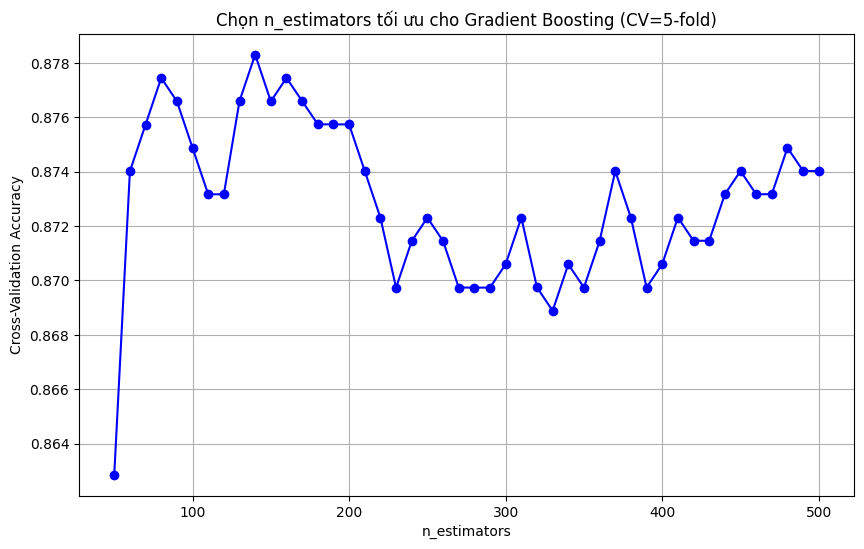

n_estimators tối ưu (CV): 140

Độ chính xác GB trên tập validation: 0.8766
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       182
           1       0.93      0.84      0.88       207

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389


Độ chính xác GB trên tập test: 0.8817
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       182
           1       0.89      0.89      0.89       207

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389



In [49]:
# 1) Tìm & train model tốt nhất trên X_train
gb_model, val_acc, best_params = evaluate_val_gb(
    X_train, y_train, X_val, y_val
)

# 2) Đánh giá test
test_acc = evaluate_test_gb(gb_model, X_test, y_test)

In [50]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [51]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier  # Changed from RandomForestClassifier
import numpy as np

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    model = GradientBoostingClassifier(
            n_estimators=n_estimators, learning_rate=learning_rate,
            max_depth=max_depth, subsample=subsample, random_state=SEED,
        )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_n_estimators = trial.params['n_estimators']
best_learning_rate = trial.params['learning_rate']
best_max_depth = trial.params['max_depth']
best_subsample = trial.params['subsample']

# Train the final model with the best hyperparameters
best_gb_model = GradientBoostingClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth, subsample=best_subsample, random_state=SEED
) # Changed from best_rf_model and added GB params
best_gb_model.fit(X_train, y_train) # Changed model name

# Evaluate on the validation set
val_pred = best_gb_model.predict(X_val) # Changed model name
val_acc_optuna = accuracy_score(y_val, val_pred)
print(f"\nĐộ chính xác Gradient Boosting trên tập validation (Optuna): {val_acc_optuna:.4f}") # Changed model name
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_gb(best_gb_model, X_test, y_test) # Changed model name

[I 2025-10-31 08:06:52,247] A new study created in memory with name: no-name-a37f3c31-c8e2-4608-9b68-6f620c2a5a38
[I 2025-10-31 08:06:54,568] Trial 0 finished with value: 0.8611459594292212 and parameters: {'n_estimators': 470, 'learning_rate': 0.029662446704503184, 'max_depth': 4, 'subsample': 0.5043843486949436}. Best is trial 0 with value: 0.8611459594292212.
[I 2025-10-31 08:06:58,945] Trial 1 finished with value: 0.8705880195150583 and parameters: {'n_estimators': 500, 'learning_rate': 0.17960930502729927, 'max_depth': 7, 'subsample': 0.7707862468262157}. Best is trial 1 with value: 0.8705880195150583.
[I 2025-10-31 08:07:02,862] Trial 2 finished with value: 0.8766002714500569 and parameters: {'n_estimators': 190, 'learning_rate': 0.10312510772136375, 'max_depth': 9, 'subsample': 0.9563998457559675}. Best is trial 2 with value: 0.8766002714500569.
[I 2025-10-31 08:07:08,144] Trial 3 finished with value: 0.8654488096548182 and parameters: {'n_estimators': 400, 'learning_rate': 0.15

Best trial:
  Value: 0.8851656212171234
  Params: 
    n_estimators: 170
    learning_rate: 0.019679584794929657
    max_depth: 10
    subsample: 0.6459641917990556

Độ chính xác Gradient Boosting trên tập validation (Optuna): 0.9023
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       182
           1       0.94      0.87      0.90       207

    accuracy                           0.90       389
   macro avg       0.90      0.90      0.90       389
weighted avg       0.90      0.90      0.90       389


Độ chính xác GB trên tập test: 0.8689
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       182
           1       0.87      0.89      0.88       207

    accuracy                           0.87       389
   macro avg       0.87      0.87      0.87       389
weighted avg       0.87      0.87      0.87       389



## XGBoost

In [52]:
# ==== 1) Tìm hyperparameters tối ưu bằng Cross-Validation ====
def find_optimal_xgb(
    X_train, y_train,
    n_estimators_range=range(50, 501, 10),
    cv_splits=5,
    learning_rate=0.1,
    max_depth=5,
    subsample=1.0,
    use_gpu=False
):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=SEED)
    scores = []

    n_classes = len(np.unique(y_train))
    objective = 'binary:logistic' if n_classes == 2 else 'multi:softprob'
    eval_metric = 'logloss' if n_classes == 2 else 'mlogloss'

    for n in n_estimators_range:
        xgb = XGBClassifier(
            n_estimators=n, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample,
            objective=objective, eval_metric=eval_metric, random_state=SEED, n_jobs=-1,
            tree_method='gpu_hist' if use_gpu else 'hist', verbosity=0
        )
        cv_score = cross_val_score(
            xgb, X_train, y_train,
            cv=cv, scoring='accuracy', n_jobs=-1
        )
        scores.append(cv_score.mean())

    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho XGBoost (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    best_n = list(n_estimators_range)[int(np.argmax(scores))]
    print(f'n_estimators tối ưu (CV): {best_n}')

    best_model = XGBClassifier(
        n_estimators=best_n, learning_rate=learning_rate, max_depth=max_depth, subsample=subsample,
        objective=objective, eval_metric=eval_metric, random_state=SEED, n_jobs=-1,
        tree_method='gpu_hist' if use_gpu else 'hist', verbosity=0
    )
    best_model.fit(X_train, y_train)
    return best_model, best_n, max(scores)

# ==== 2) Đánh giá trên tập validation ====
def evaluate_val_xgb(X_train, y_train, X_val, y_val,
                     n_estimators_range=range(50, 501, 10), cv_splits=5,
                     learning_rate=0.1, max_depth=5, subsample=1.0,
                     colsample_bytree=1.0, use_gpu=False):
    print('Tìm n_estimators tối ưu cho XGBoost...')
    xgb_model, best_n, cv_acc = find_optimal_xgb(
        X_train, y_train, n_estimators_range=n_estimators_range,
        cv_splits=cv_splits, learning_rate=learning_rate,
        max_depth=max_depth, subsample=subsample, use_gpu=use_gpu
    )

    val_pred = xgb_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f'\nĐộ chính xác XGBoost trên tập validation: {val_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_val, val_pred))
    return xgb_model, val_acc, {'n_estimators': best_n}

# ==== 3) Đánh giá trên tập test ====
def evaluate_test_xgb(xgb_model, X_test, y_test):
    test_pred = xgb_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f'\nĐộ chính xác XGBoost trên tập test: {test_acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, test_pred))
    return test_acc

Tìm n_estimators tối ưu cho XGBoost...


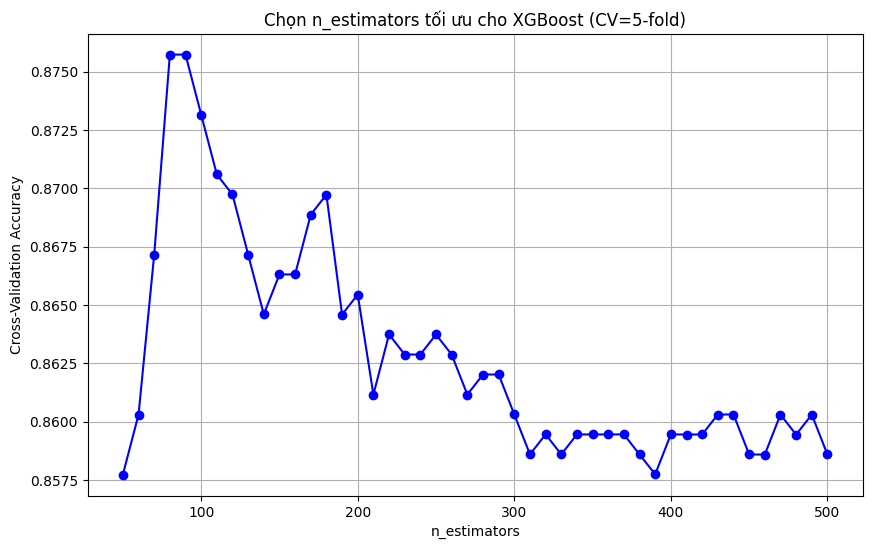

n_estimators tối ưu (CV): 80

Độ chính xác XGBoost trên tập validation: 0.8920
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       182
           1       0.93      0.86      0.89       207

    accuracy                           0.89       389
   macro avg       0.89      0.89      0.89       389
weighted avg       0.89      0.89      0.89       389


Độ chính xác XGBoost trên tập test: 0.8638
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       182
           1       0.87      0.88      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



In [53]:
# 1) Tìm & train model tốt nhất trên X_train
xgb_model, val_acc, best_params = evaluate_val_xgb(
    X_train, y_train, X_val, y_val
)

# 2) Đánh giá test
test_acc = evaluate_test_xgb(xgb_model, X_test, y_test)

Tìm n_estimators tối ưu cho XGBoost...


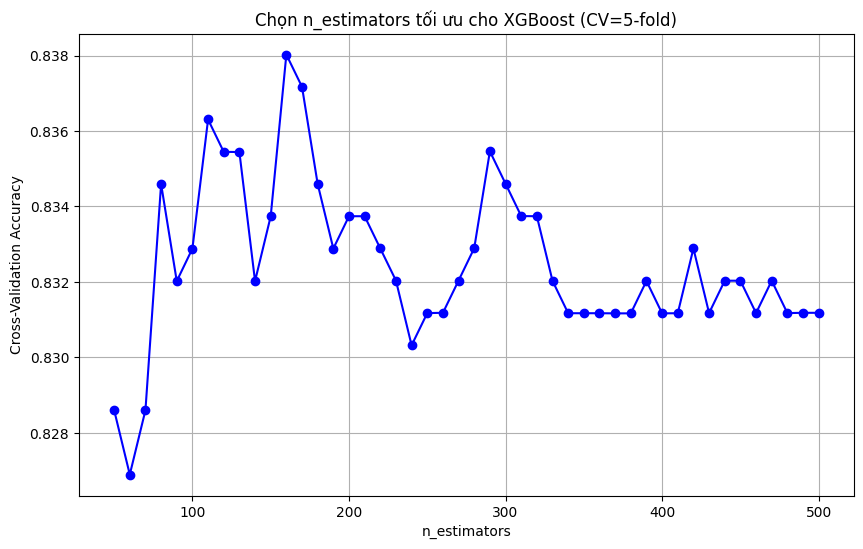

n_estimators tối ưu (CV): 160

Độ chính xác XGBoost trên tập validation: 0.8766
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       182
           1       0.90      0.87      0.88       207

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389


Độ chính xác XGBoost trên tập test: 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       182
           1       0.86      0.87      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



In [54]:
# 1) Tìm & train model tốt nhất trên X_train
xgb_model, val_fe_acc, best_params = evaluate_val_xgb(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val
)

# 2) Đánh giá test
test_fe_acc = evaluate_test_xgb(xgb_model, X_fe_test, y_fe_test)

Tìm n_estimators tối ưu cho XGBoost...


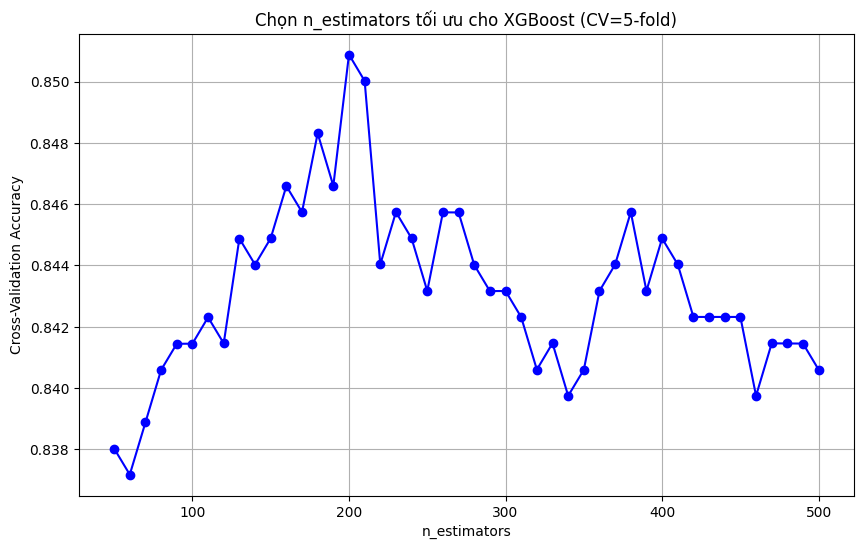

n_estimators tối ưu (CV): 200

Độ chính xác XGBoost trên tập validation: 0.8663
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       182
           1       0.89      0.85      0.87       207

    accuracy                           0.87       389
   macro avg       0.87      0.87      0.87       389
weighted avg       0.87      0.87      0.87       389


Độ chính xác XGBoost trên tập test: 0.8535
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       182
           1       0.86      0.86      0.86       207

    accuracy                           0.85       389
   macro avg       0.85      0.85      0.85       389
weighted avg       0.85      0.85      0.85       389



In [55]:
# 1) Tìm & train model tốt nhất trên X_train
xgb_model, val_dt_acc, best_params = evaluate_val_xgb(
    X_dt_train, y_dt_train, X_dt_val, y_dt_val
)

# 2) Đánh giá test
test_dt_acc = evaluate_test_xgb(xgb_model, X_dt_test, y_dt_test)

Tìm n_estimators tối ưu cho XGBoost...


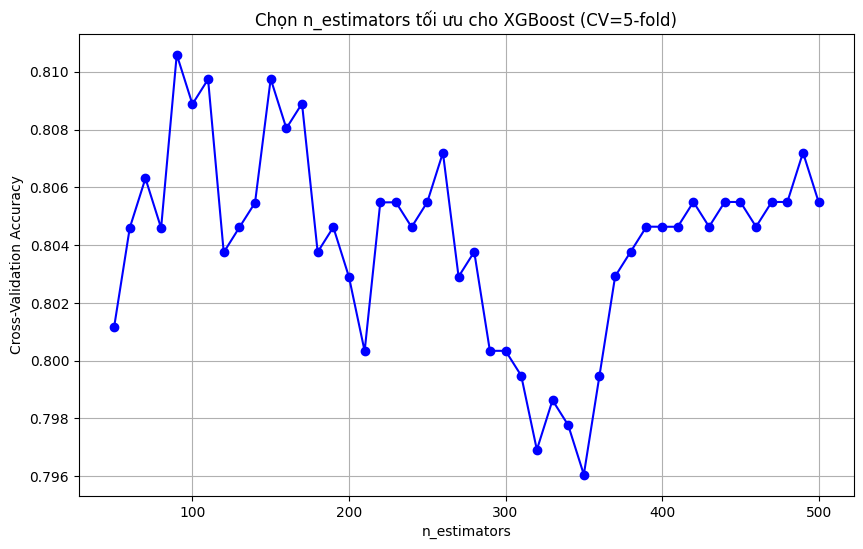

n_estimators tối ưu (CV): 90

Độ chính xác XGBoost trên tập validation: 0.8278
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       182
           1       0.84      0.84      0.84       207

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389


Độ chính xác XGBoost trên tập test: 0.8098
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       182
           1       0.82      0.83      0.82       207

    accuracy                           0.81       389
   macro avg       0.81      0.81      0.81       389
weighted avg       0.81      0.81      0.81       389



In [56]:
# 1) Tìm & train model tốt nhất trên X_train
xgb_model, val_fe_dt_acc, best_params = evaluate_val_xgb(
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val,
)

# 2) Đánh giá test
test_fe_dt_acc = evaluate_test_xgb(xgb_model, X_fe_dt_test, y_fe_dt_test)

In [57]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier # Changed from GradientBoostingClassifier
import numpy as np

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.01)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01)

    model = XGBClassifier(n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          max_depth=max_depth,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          random_state=SEED,
                          use_label_encoder=False,
                          eval_metric='logloss') # Added XGBoost specific parameters
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_xgb_model = XGBClassifier(
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    max_depth=trial.params['max_depth'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
) # Changed model name and added XGBoost params

best_xgb_model.fit(X_train, y_train) # Changed model name

# Evaluate on the validation set
val_pred = best_xgb_model.predict(X_val) # Changed model name
val_acc_optuna = accuracy_score(y_val, val_pred)
print(f"\nĐộ chính xác XGBoost trên tập validation (Optuna): {val_acc_optuna:.4f}") # Changed model name
print("Classification Report:")
print(classification_report(y_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_xgb(best_xgb_model, X_test, y_test) # Changed model name

[I 2025-10-31 08:16:46,552] A new study created in memory with name: no-name-dcc00ea3-a6af-4254-8921-a837a29cafc5
[I 2025-10-31 08:16:47,052] Trial 0 finished with value: 0.859458567183889 and parameters: {'n_estimators': 360, 'learning_rate': 0.27, 'max_depth': 7, 'subsample': 0.94, 'colsample_bytree': 0.9299999999999999}. Best is trial 0 with value: 0.859458567183889.
[I 2025-10-31 08:16:47,561] Trial 1 finished with value: 0.8508822126847878 and parameters: {'n_estimators': 430, 'learning_rate': 0.24000000000000002, 'max_depth': 5, 'subsample': 0.65, 'colsample_bytree': 0.5700000000000001}. Best is trial 0 with value: 0.859458567183889.
[I 2025-10-31 08:16:47,726] Trial 2 finished with value: 0.8560067495689815 and parameters: {'n_estimators': 60, 'learning_rate': 0.3, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.96}. Best is trial 0 with value: 0.859458567183889.
[I 2025-10-31 08:16:48,093] Trial 3 finished with value: 0.8680275851949671 and parameters: {'n_estimators':

Best trial:
  Value: 0.8868676864385019
  Params: 
    n_estimators: 330
    learning_rate: 0.01
    max_depth: 9
    subsample: 0.89
    colsample_bytree: 0.6799999999999999

Độ chính xác XGBoost trên tập validation (Optuna): 0.9100
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       182
           1       0.93      0.90      0.91       207

    accuracy                           0.91       389
   macro avg       0.91      0.91      0.91       389
weighted avg       0.91      0.91      0.91       389


Độ chính xác XGBoost trên tập test: 0.8817
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       182
           1       0.87      0.92      0.89       207

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.88       389
weighted avg       0.88      0.88      0.88       389



In [58]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.01)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01)

    model = XGBClassifier(n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          max_depth=max_depth,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          random_state=SEED,
                          use_label_encoder=False,
                          eval_metric='logloss') # Added XGBoost specific parameters
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_fe_train, y_fe_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_xgb_model = XGBClassifier(
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    max_depth=trial.params['max_depth'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
) # Changed model name and added XGBoost params

best_xgb_model.fit(X_fe_train, y_fe_train) # Changed model name

# Evaluate on the validation set
val_pred = best_xgb_model.predict(X_fe_val) # Changed model name
val_acc_optuna = accuracy_score(y_fe_val, val_pred)
print(f"\nĐộ chính xác XGBoost trên tập validation (Optuna): {val_acc_optuna:.4f}") # Changed model name
print("Classification Report:")
print(classification_report(y_fe_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_xgb(best_xgb_model, X_fe_test, y_fe_test) # Changed model name

[I 2025-10-31 08:17:54,179] A new study created in memory with name: no-name-2eae2f26-43f2-461f-9aac-c0cf6482da62
[I 2025-10-31 08:17:54,659] Trial 0 finished with value: 0.8071897582627197 and parameters: {'n_estimators': 470, 'learning_rate': 0.16, 'max_depth': 3, 'subsample': 0.66, 'colsample_bytree': 0.8400000000000001}. Best is trial 0 with value: 0.8071897582627197.
[I 2025-10-31 08:17:54,883] Trial 1 finished with value: 0.8243314625288874 and parameters: {'n_estimators': 90, 'learning_rate': 0.29000000000000004, 'max_depth': 8, 'subsample': 0.75, 'colsample_bytree': 0.53}. Best is trial 1 with value: 0.8243314625288874.
[I 2025-10-31 08:17:55,384] Trial 2 finished with value: 0.8140273651003265 and parameters: {'n_estimators': 360, 'learning_rate': 0.25, 'max_depth': 4, 'subsample': 0.6799999999999999, 'colsample_bytree': 0.9299999999999999}. Best is trial 1 with value: 0.8243314625288874.
[I 2025-10-31 08:17:55,690] Trial 3 finished with value: 0.789156670701735 and parameters

Best trial:
  Value: 0.8448956384578702
  Params: 
    n_estimators: 80
    learning_rate: 0.06999999999999999
    max_depth: 10
    subsample: 0.99
    colsample_bytree: 0.6

Độ chính xác XGBoost trên tập validation (Optuna): 0.8972
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       182
           1       0.92      0.88      0.90       207

    accuracy                           0.90       389
   macro avg       0.90      0.90      0.90       389
weighted avg       0.90      0.90      0.90       389


Độ chính xác XGBoost trên tập test: 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       182
           1       0.85      0.89      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



In [59]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)
    max_depth = trial.suggest_int('max_depth', 3, 10, step=1)
    subsample = trial.suggest_float('subsample', 0.5, 1.0, step=0.01)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01)

    model = XGBClassifier(n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          max_depth=max_depth,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          random_state=SEED,
                          use_label_encoder=False,
                          eval_metric='logloss') # Added XGBoost specific parameters
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(model, X_dt_train, y_dt_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_xgb_model = XGBClassifier(
    n_estimators=trial.params['n_estimators'],
    learning_rate=trial.params['learning_rate'],
    max_depth=trial.params['max_depth'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
) # Changed model name and added XGBoost params

best_xgb_model.fit(X_dt_train, y_dt_train) # Changed model name

# Evaluate on the validation set
val_pred = best_xgb_model.predict(X_dt_val) # Changed model name
val_acc_optuna = accuracy_score(y_dt_val, val_pred)
print(f"\nĐộ chính xác XGBoost trên tập validation (Optuna): {val_acc_optuna:.4f}") # Changed model name
print("Classification Report:")
print(classification_report(y_dt_val, val_pred))

# Evaluate on the test set
test_acc_optuna = evaluate_test_xgb(best_xgb_model, X_dt_test, y_dt_test) # Changed model name

[I 2025-10-31 08:18:37,474] A new study created in memory with name: no-name-3c0c8fc9-ab0f-4710-a41c-41f09a64d25a
[I 2025-10-31 08:18:38,351] Trial 0 finished with value: 0.845743002824548 and parameters: {'n_estimators': 470, 'learning_rate': 0.04, 'max_depth': 10, 'subsample': 0.52, 'colsample_bytree': 0.75}. Best is trial 0 with value: 0.845743002824548.
[I 2025-10-31 08:18:38,891] Trial 1 finished with value: 0.8448846337258356 and parameters: {'n_estimators': 320, 'learning_rate': 0.17, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.8500000000000001}. Best is trial 0 with value: 0.845743002824548.
[I 2025-10-31 08:18:39,645] Trial 2 finished with value: 0.8585818568651187 and parameters: {'n_estimators': 440, 'learning_rate': 0.04, 'max_depth': 7, 'subsample': 0.95, 'colsample_bytree': 0.67}. Best is trial 2 with value: 0.8585818568651187.
[I 2025-10-31 08:18:40,001] Trial 3 finished with value: 0.8602985950625435 and parameters: {'n_estimators': 140, 'learning_rate': 0.0

Best trial:
  Value: 0.8705916877590697
  Params: 
    n_estimators: 70
    learning_rate: 0.05
    max_depth: 9
    subsample: 1.0
    colsample_bytree: 0.87

Độ chính xác XGBoost trên tập validation (Optuna): 0.8869
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       182
           1       0.90      0.88      0.89       207

    accuracy                           0.89       389
   macro avg       0.89      0.89      0.89       389
weighted avg       0.89      0.89      0.89       389


Độ chính xác XGBoost trên tập test: 0.8586
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       182
           1       0.86      0.88      0.87       207

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



## 4.Result Visualization

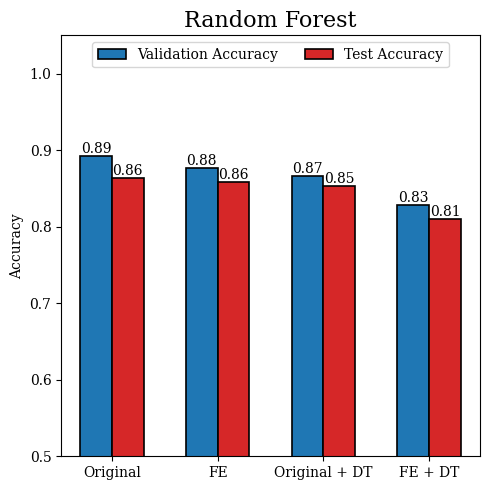

In [60]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', "FE + DT"]
val_accs = [val_acc, val_fe_acc, val_dt_acc, val_fe_dt_acc]
test_accs = [test_acc, test_fe_acc, test_dt_acc, test_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(5, 5))

rects1 = ax.bar(x - width/2, val_accs,  width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("accuracy_comparison.pdf", bbox_inches="tight")
plt.show()


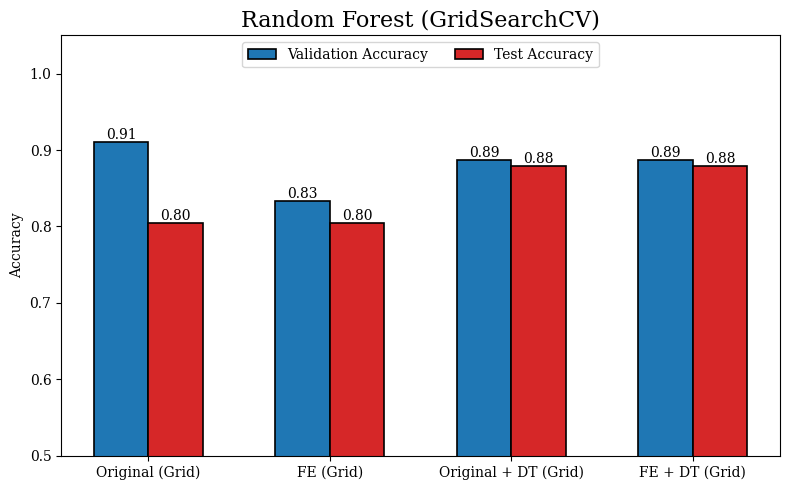

In [61]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original (Grid)', 'FE (Grid)', 'Original + DT (Grid)', "FE + DT (Grid)"]
val_accs = [valgrid_acc, valgrid_fe_acc, valgrid_dt_acc, valgrid_fe_dt_acc]
test_accs = [testgrid_fe_acc, testgrid_fe_acc, testgrid_fe_dt_acc, testgrid_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, val_accs,  width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest (GridSearchCV)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("accuracy_comparison.pdf", bbox_inches="tight")
plt.show()

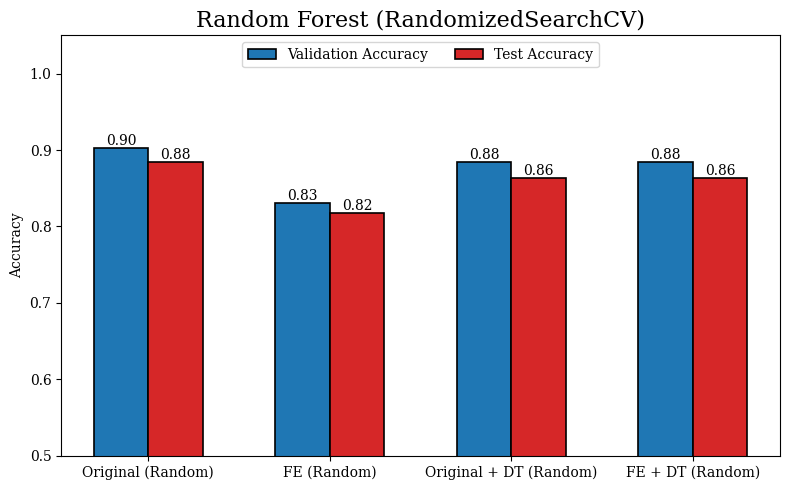

In [62]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original (Random)', 'FE (Random)', 'Original + DT (Random)', "FE + DT (Random)"]
val_accs = [valrd_acc, valrd_fe_acc, valrd_dt_acc, valrd_dt_acc]
test_accs = [testrd_acc, testrd_fe_acc, testrd_fe_dt_acc, testrd_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x - width/2, val_accs,  width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('Random Forest (RandomizedSearchCV)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("accuracy_comparison.pdf", bbox_inches="tight")
plt.show()